In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
from pylab import *
import matplotlib
#import plplot
from scipy import stats
#from io import StringIO
print(pd.__version__)
#AttributeError: 'Series' object has no attribute 'to_numpy'
import re

import math
import astropy as astro
import scipy.ndimage as spimage
from astropy.io import fits, ascii
from astropy.table import Table, join
from astropy.cosmology import WMAP9 as cosmo
import matplotlib as mpl
#from numpy import std as biweight_midvariance
import matplotlib.cm as cm

from scipy import optimize
from scipy.stats import gaussian_kde
from matplotlib import colors
import scipy.ndimage as ndimage
from collections import Counter
from matplotlib.legend import Legend
import matplotlib.patches as patches
from matplotlib import pyplot
from mpl_toolkits.axes_grid1 import make_axes_locatable
#
#
#
import extinction


#
# seaborn
#import pandas.util.testing as tm
import seaborn as sns

#
# Jorge
#

from sel2dhist_xy import sel2dhist_xy


#
# 3D plots!
#
import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

#biweight_midvariance


import warnings
warnings.simplefilter("ignore")

#
# my_utils
#
from my_utils import *

#
#
#
from ndtest import *
from sklearn.decomposition import PCA

#
#
#
from scipy.optimize import leastsq, fmin
import matplotlib.animation as animation

#
# Carlos Color map
#
from cmaps_CLC import vel_map

from scipy.spatial import KDTree


import collections

import scipy.stats as st

2.2.0
2.2.0


In [6]:
from matplotlib import rcParams as rc
rc.update({'font.size': 20,\
           'font.weight': 900,\
           'text.usetex': True,\
           'path.simplify'           :   True,\
           'xtick.labelsize' : 20,\
           'ytick.labelsize' : 20,\
#           'xtick.major.size' : 3.5,\
#           'ytick.major.size' : 3.5,\
           'axes.linewidth'  : 2.0,\
               # Increase the tick-mark lengths (defaults are 4 and 2)
           'xtick.major.size'        :   6,\
           'ytick.major.size'        :   6,\
           'xtick.minor.size'        :   3,\
           'ytick.minor.size'        :   3,\
           'xtick.major.width'       :   1,\
           'ytick.major.width'       :   1,\
           'lines.markeredgewidth'   :   1,\
           'legend.numpoints'        :   1,\
           'xtick.minor.width'       :   1,\
           'ytick.minor.width'       :   1,\
           'legend.frameon'          :   False,\
           'legend.handletextpad'    :   0.3,\
           'font.family'    :   'serif',\
           'mathtext.fontset'        :   'stix',\
           'axes.facecolor' : "w",\
           
          })


READING TABLES

In [9]:
hdu = fits.open('tables/KG_Pipe3D_table_COSMO.fits')
tab = Table(hdu[1].data)
tab.rename_column('name','org_name')
tab.rename_column('cubename','name')

In [10]:
def my_contour(ax,x_cont,y_cont,x_min,x_max,y_min,y_max,c_color='red', title='', nbins=30, zorder=1, linewidths=2,alpha=0.75):
    N_min=2
    Delta=0.3
#    nbins=30
    mask_cont = (x_cont>x_min) & (x_cont<x_max) & (y_cont>y_min) & (y_cont<y_max)  
    x_plt, y_plt = x_cont[mask_cont], y_cont[mask_cont]
    counts, xbins, ybins = np.histogram2d(x_plt, y_plt, bins=nbins,
        normed=True,range=[[x_min,x_max],[y_min,y_max]])
    counts=ndimage.gaussian_filter(counts, sigma=1, order=0)
    counts /= counts.max()
    sum_total=counts.sum()
    vals=[]
    levels=[]
    for idx,cuts in enumerate(np.arange(0.00,1.0,0.01)):
        mask_now= counts>cuts
        levels.append(cuts)
        vals.append(counts[mask_now].sum()/sum_total)
    vals_cont=np.array([0.95,0.65,0.40])
    levels_cont=np.interp(vals_cont,np.array(levels),np.array(vals))
    counts_rot=np.rot90(counts,3)
    xbins=xbins+0.5*(x_max-x_min)/nbins
    ybins=ybins+0.5*(y_max-y_min)/nbins
    flip_counts_rot=np.fliplr(counts_rot)
    p_cont=ax.contour(xbins[0:nbins],ybins[0:nbins],flip_counts_rot,levels_cont,\
                      colors=c_color,alpha=alpha,linewidths=linewidths,zorder=zorder)
#    labels = ['Div Neg', 'Div Pos', 'Rot Neg', 'Rot Pos']
    if (len(title)>0):
        p_cont.collections[0].set_label(title)
    #    h_cont,l_cont = p_cont.legend_elements(title)
#    ax.legend(h_cont, l_cont)

def biweight_midvariance(par):
    val=np.nanstd(par)/np.sqrt(2)
    return val

def my_scatter(ax,x_par,y_par,c_par,x_cont,y_cont,x_min,x_max,y_min,y_max,c_min,c_max,x_label,y_label,xf_min=0.0,yf_min=0.0,den_par_min=0.85,bin_size=0.3,bin_number=2,c_color="black",c_color2="darksalmon",error=0.05,MC=10, Delta=0.15):
    cm = califa_vel_r
    if (xf_min==0.0):
        xf_min=x_min
    if (yf_min==0.0):
        yf_min=y_min
#    MC=5
#    error=0.05
    N_min=2
#    Delta=0.15
#    den_par_min=0.9
    nbins=30
    lEW_cut=0.78 #0.78
    n_obj_org=len(x_par)
#    print("# N.OBJ = ",n_obj_org)
#    mask = (x_par>x_min) & (x_par<x_max) & (y_par>y_min) & (y_par<y_max)  
    mask = x_par>-20
    n_obj=len(x_par[mask])
#    print(x_par[~mask])
#    print("# N.Obj = ",n_obj,x_min,x_max,y_min,y_max)
    mask_SFGs = mask & (c_par>lEW_cut)
    mask_cont = (x_cont>x_min) & (x_cont<x_max) & (y_cont>y_min) & (y_cont<y_max)  
#
# Density to plot!
#
    x_plt, y_plt = x_cont[mask_cont], y_cont[mask_cont]
#    nbins=40
    counts, xbins, ybins = np.histogram2d(x_plt, y_plt, bins=nbins,
        normed=True,range=[[x_min,x_max],[y_min,y_max]])
#        range=[[np.nanmin(x_plt),np.nanmax(x_plt)],[np.nanmin(y_plt),np.nanmax(y_plt)]])
                                            #    counts /= counts.max()

    counts=ndimage.gaussian_filter(counts, sigma=1, order=0)
    counts /= counts.max()
    sum_total=counts.sum()
    vals=[]
    levels=[]
    for idx,cuts in enumerate(np.arange(0.00,1.0,0.01)):
        mask_now= counts>cuts
        levels.append(cuts)
        vals.append(counts[mask_now].sum()/sum_total)
        #print(idx,levels[idx],vals[idx])
    vals_cont=np.array([0.95,0.80,0.40])
    levels_cont=np.interp(vals_cont,np.array(levels),np.array(vals))
    figure=ax.scatter(x_par, y_par, c=c_par, vmin=c_min,vmax=c_max,alpha=0.4,edgecolor='none',\
                      rasterized=True,cmap=cm)
    counts_rot=np.rot90(counts,3)
    xbins=xbins+0.5*(x_max-x_min)/nbins
    ybins=ybins+0.5*(y_max-y_min)/nbins
    flip_counts_rot=np.fliplr(counts_rot)
    p_cont=ax.contour(xbins[0:nbins],ybins[0:nbins],flip_counts_rot,levels_cont,colors=c_color)

    #
    # Density near a point
    #
    x_plt, y_plt = x_par[mask_SFGs], y_par[mask_SFGs]
    n_sf=len(x_par[mask_SFGs])
    #    nbins=40
    counts, xbins, ybins = np.histogram2d(x_plt, y_plt, bins=nbins,
        normed=True,
        range=[[np.nanmin(x_plt),np.nanmax(x_plt)],[np.nanmin(y_plt),np.nanmax(y_plt)]])
                                            #    counts /= counts.max()
#    print(xbins,ybins)
    counts=ndimage.gaussian_filter(counts, sigma=1, order=0)
    counts /= counts.max()
    sum_total=counts.sum()
    vals_new=[]
    levels_new=[]
    for idx,cuts in enumerate(np.arange(0.00,1.0,0.01)):
        mask_now= counts>cuts
        levels_new.append(cuts)
        vals_new.append(counts[mask_now].sum()/sum_total)
        #print(idx,levels[idx],vals[idx])
    vals_cont=np.array([0.95,0.80,0.40])
    levels_cont=np.interp(vals_cont,np.array(levels_new),np.array(vals))
    
#    figure=ax.scatter(x_par, y_par, c=c_par, vmin=c_min,vmax=c_max,alpha=0.4,edgecolor='none',cmap=cm)
    counts_rot=np.rot90(counts,3)
    xbins=xbins+0.5*(x_max-x_min)/nbins
    ybins=ybins+0.5*(y_max-y_min)/nbins
    flip_counts_rot=np.fliplr(counts_rot)
    
  
    den_par=np.zeros(len(x_par))
    for i in range(len(x_par)):
        if ((np.isfinite(x_par[i])) and (np.isfinite(y_par[i]))):
            i_x=np.argmin(np.abs(xbins-x_par[i]))
            i_y=np.argmin(np.abs(ybins-y_par[i]))
            if ((i_x>0) and (i_x<nbins) and (i_y>0) and (i_y<nbins)):
                den_par[i]=np.interp(counts[i_x,i_y],np.array(levels_new),np.array(vals_new))

# Density plot!
#    figure=ax.scatter(x_par, y_par, c=den_par, vmin=0,vmax=1,alpha=0.4,edgecolor='none',cmap=cm)
    p_cont2=ax.contour(xbins[0:nbins],ybins[0:nbins],flip_counts_rot,levels_cont,colors=c_color2)
#
# We mask low density points
#
#    print("# den_par_min=",den_par_min)
    mask_SFGs = mask_SFGs & (den_par<den_par_min) & \
    np.logical_not(np.isnan(x_par)) & np.isfinite(x_par) & \
    np.logical_not(np.isnan(y_par)) & np.isfinite(y_par)  

    x_sf=x_par[mask_SFGs]
    y_sf=y_par[mask_SFGs]
    
#    figure=ax.scatter(x_par, y_par, c=den_par, vmin=0,vmax=1,alpha=0.4,edgecolor='none',cmap=cm)
    
    bin1 , min1 , max1= Delta,x_min,x_max
    m1, sM1, sD1 = binning_M(x_sf, y_sf, bin1 , min1 , max1, N_min, bin_size, bin_number )
    p1 = ax.errorbar(m1, sM1, yerr= sD1, markersize = 9, markerfacecolor =c_color2, markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = '', zorder=2, alpha=0.7)


#    x_sf=x_par[mask_SFGs]
#    y_sf=y_par[mask_SFGs]
    bin1 , min1 , max1= Delta,xf_min,x_max
    funct    = lambda x,a,b: a + b * x
    START=[-1,1.0]
    pa1=np.zeros(2)
    ea1=np.zeros(2)
#    print('#vals to fit =',m1,sM1,sD1)
    if m1.size > 2:
        m1, sM1, sD1 = binning_M(x_sf, y_sf, bin1 , min1 , max1, N_min, 0.3,2 )
        mean_sD1=np.nanmean(sD1)
        sD1=sD1+mean_sD1
        np.clip(sD1,0.5*mean_sD1,1.5*mean_sD1)
        pa1, ea1  = optimize.curve_fit(funct, m1, sM1, sigma=np.sqrt(sD1), p0 = START )
        a_pa=np.zeros((MC,2))
        a_ea=np.zeros((MC,2,2))
        a_rc=np.zeros((MC,2,2))
        for iMC in range(MC):
            e_x_sf=np.abs(2*error-error*(x_sf-x_min)/(x_max-x_min))
            e_y_sf=np.abs(2*error-error*(y_sf-y_min)/(y_max-y_min))
            
#            print('e_y=',e_y_sf,len(e_y_sf))
#            print('e-x=',e_x_sf,len(e_x_sf))
            x_sf_now=x_sf+np.random.normal(loc=0.0,scale=e_x_sf,size=len(e_x_sf))
            y_sf_now=y_sf+np.random.normal(loc=0.0,scale=e_y_sf,size=len(e_y_sf))
            mNOW, sMNOW, sDNOW = binning_M(x_sf_now, y_sf_now, bin1 , min1 , max1, N_min, 0.3,2 )
            rcNOW=np.corrcoef(x_sf_now, y_sf_now)
            #for i in range(len(sDNOW)):
            #    i_x=np.argmin(np.abs(xbins-mNOW[i]))
            #    i_y=np.argmin(np.abs(ybins-sMNOW[i]))
            #    if ((i_x>0) and (i_x<nbins) and (i_y>0) and (i_y<nbins)):
            #        sDNOW[i]=0.5*sDNOW[i]+\
            #        0.1*np.interp(counts[i_x,i_y],np.array(levels_new),np.array(vals_new))
#                    if (iMC==0):
#                        print(mNOW[i],sDNOW[i])
            sDNOW=0.001/sDNOW
    
#            np.clip(sDNOW,0.05,0.2)
            paNOW, eaNOW  = optimize.curve_fit(funct, mNOW, sMNOW, sigma=np.sqrt(sDNOW), p0 = START )
#            print('Coeffs lin fit: ',round(paNOW[0],3),round(np.sqrt(np.diag(eaNOW))[0],3),round(paNOW[1],3),round(np.sqrt(np.diag(eaNOW))[1],3),round(rcNOW[0,1],3))    
            a_pa[iMC,:]=paNOW
            a_ea[iMC,:,:]=eaNOW
            a_rc[iMC,:,:]=rcNOW
#        print(pa1,ea1)
#        test=np.mean(a_pa,axis=(0,1))
#        print(test)
        np.mean(a_pa, axis=(0), out=pa1)
        np.mean(a_ea, axis=(0), out=ea1)
        e_pa1=np.std(a_pa, axis=(0))
        rc=np.mean(a_rc, axis=(0))
        ea1[0,0]=ea1[0,0]+e_pa1[0]
        ea1[1,1]=ea1[1,1]+e_pa1[1]
        
        
        #        pa1=a_pa.mean(axis=(1,2))
#        ea1=a_ea.mean(axis=(1,2))
#        ea1=np.mean(a_ea,axis=2)
        
#        pa1, ea1  = optimize.curve_fit(funct, m1, sM1, sigma=sD1, p0 = START )
#round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3),round(pa1[1],3),round(np.sqrt(np.diag(ea1))[1],3),round(rc[0,1],3)

        if (xf_min!=x_min):
            yl_plot=np.linspace(y_min,y_max,10)
            xl_plot=xf_min+0.0*yl_plot
            rect=patches.Rectangle((x_min, y_min), xf_min-x_min, y_max-y_min, facecolor="black", alpha=0.2,zorder=3)
            ax.add_patch(rect)
        x_plot=np.linspace(np.min(m1)-1.5*bin1, np.max(m1)+1.5*bin1, 10)
        y_plot=funct(x_plot,pa1[0],pa1[1])
        p_fit=ax.plot(x_plot, y_plot, '-.', linewidth = 3, markerfacecolor ='black'  , color ='black', zorder=3,label='This work')
#        p_fit=ax.plot(xl_plot, yl_plot, '-', linewidth = 2, markerfacecolor ='grey'  , color ='grey', zorder=2)        
#        print("PASO")

    mask_SFGs = mask_SFGs & (den_par<0.85) & \
    np.logical_not(np.isnan(x_par)) & np.isfinite(x_par) & \
    np.logical_not(np.isnan(y_par)) & np.isfinite(y_par)  

    x_sf=x_par[mask_SFGs]
    y_sf=y_par[mask_SFGs]

    mask_x_sf=x_sf>xf_min
    x_sf=x_sf[mask_x_sf]
    y_sf=y_sf[mask_x_sf]
    rc=np.corrcoef(x_sf, y_sf)
    delta_y_par=y_sf-(pa1[0]+pa1[1]*x_sf)
    s_y_par = biweight_midvariance(y_sf[np.isfinite(y_sf)])
    s_dy_par = biweight_midvariance(delta_y_par[np.isfinite(delta_y_par)])

#    s_y_par = np.std(y_sf[np.isfinite(y_sf)])
#    s_dy_par = np.std(delta_y_par[np.isfinite(delta_y_par)])

    print('Mean Coeff.: ',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3),round(pa1[1],3),round(np.sqrt(np.diag(ea1))[1],3),round(rc[0,1],3),round(s_y_par,3),round(s_dy_par,3),n_obj,n_sf)
    #    print('Stddev: ',round(s_y_par,3),round(s_dy_par,3))
        
    ax.set_xlim([x_min,x_max])
    ax.set_ylim([y_min,y_max])    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.minorticks_on()
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(which='both',direction="in")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    return pa1,ea1,s_y_par,s_dy_par,rc

def my_hist(ax,x_par,y_par,x_min,x_max,c_x,c_y,x_label,y_label):
    mask_x = (x_par > x_min) & (x_par < x_max) 
    mask_y = (y_par > x_min) & (y_par < x_max) 
    p1=sns.distplot(x_par[mask_x],bins=40,ax=ax,hist=False,color=c_x)
    p2=sns.distplot(y_par[mask_y],bins=40,ax=ax,hist=False,color=c_y)
    ax.set_xlim([x_min,x_max])
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    return p1,p2

#


In [ ]:
#
# Map plots!
#
#
# Reading the Pipe3D dataproducts
#
DIR='data/'
name_now="KG-MaNGA-1-207"
dat=name_now.split("-")
plate=dat[1]
ifu=dat[2]
DIR_plate=DIR
Pipe3D_file=DIR_plate+name_now+".Pipe3D.cube.fits.gz"
Pipe3D_hdu=fits.open(Pipe3D_file)
print(Pipe3D_hdu.info())


PE_file=DIR+name_now+".P_E.cube.fits.gz"
PE_hdu=fits.open(PE_file)
print(PE_hdu.info())

OH_file=DIR+name_now+".OH.cube.fits.gz"
OH_hdu=fits.open(OH_file)
print(OH_hdu.info())

Filename: data/KG-MaNGA-1-207.Pipe3D.cube.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  ORG_HDR       1 PrimaryHDU      97   ()      
  1  SSP           1 ImageHDU       118   (44, 44, 21)   float64   
  2  SFH           1 ImageHDU      1608   (44, 44, 319)   float64   
  3  INDICES       1 ImageHDU        31   (44, 44, 18)   float64   
  4  ELINES        1 ImageHDU        68   (44, 44, 11)   float64   
  5  FLUX_ELINES    1 ImageHDU      1382   (44, 44, 456)   float64   
  6  FLUX_ELINES_LONG    1 ImageHDU      4622   (44, 44, 1536)   float64   
  7  GAIA_MASK     1 ImageHDU        28   (44, 44)   float64   
  8  SELECT_REG    1 ImageHDU        10   (44, 44)   float64   
None
Filename: data/KG-MaNGA-1-207.P_E.cube.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     110   (44, 44, 20)   float64   
None
Filename: data/KG-MaNGA-1-207.OH.cube.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Fo

DESC_0 pseudo V-band map
DESC_1  continuum segmentation file
DESC_2  continuum dezonification file
DESC_3  median intensity flux within the wavelength range
DESC_4  StdDev median intensity flux within the wavelength range
DESC_5  luminosity weighted age of the stellar population
DESC_6  mass weighted age of the stellar population
DESC_7  error of the age of the stellar population
DESC_8  luminosity weighted metallicity of the stellar population
DESC_9  mass weighted metallicity of the stellar population
DESC_10  error metallicity of the stellar population
DESC_11  average dust attnuation of the stellar population
DESC_12  error of the average dust attnuation of the stellar population
DESC_13  velocity of the stellar population
DESC_14  error in the velocity of the stellar population
DESC_15  velocity dispersion of the stellar population
DESC_16  error in velocity dispersion of the stellar population
DESC_17  average mass-to-light ratio of the stellar population
DESC_18  stellar mass de

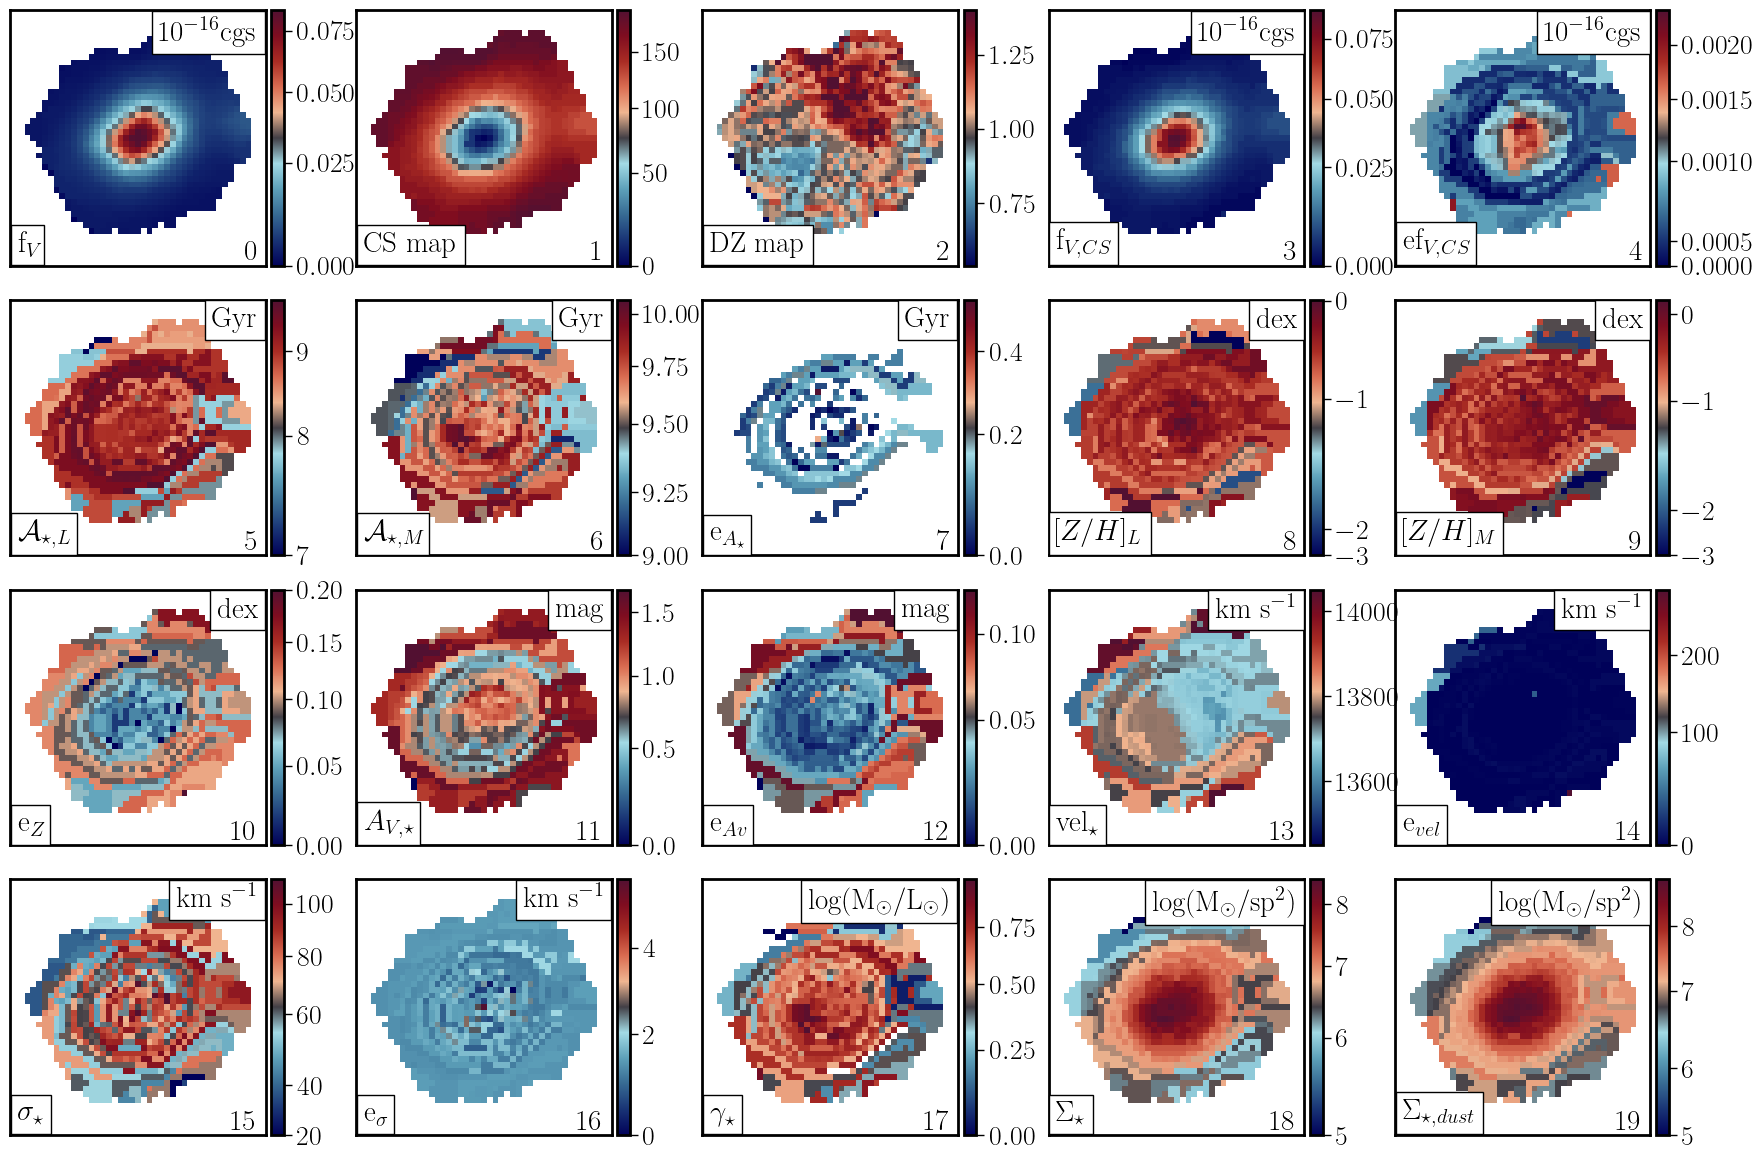

In [12]:
figname=name_now+".SSP"
SELECT_REG_data=Pipe3D_hdu[8].data
SSP_data=Pipe3D_hdu[1].data
SSP_hdr=Pipe3D_hdu[1].header
(nz,ny,nx)=SSP_data.shape
SSP_maps={}
#labels=['V-band img','CS map','DZ map','']
#for i in arange(0,nz,1):
#    key='DESC_'+str(i)
#    val=SSP_hdr[key]
#print(SELECT_REG_data)

SSP_labels={}#np.zeros(nz)
SSP_labels[0]=r'f$_V$'
SSP_labels[1]='CS map'
SSP_labels[2]='DZ map'
SSP_labels[3]=r'f$_{V,CS}$'#DESC_3  median intensity flux within the wavelength range
SSP_labels[4]=r'ef$_{V,CS}$'#  StdDev median intensity flux within the wavelength range
SSP_labels[5]=r'$\mathcal{A}_{\star,L}$'#  luminosity weighted age of the stellar population
SSP_labels[6]=r'$\mathcal{A}_{\star,M}$'#  mass weighted age of the stellar population
SSP_labels[7]=r'e$_{A_\star}$'  #error of the age of the stellar population
SSP_labels[8]=r'$[Z/H]_L$'#  luminosity weighted metallicity of the stellar population
SSP_labels[9]=r'$[Z/H]_M$'#  mass weighted metallicity of the stellar population
SSP_labels[10]=r'e$_{Z}$'#  error metallicity of the stellar population
SSP_labels[11]=r'$A_{V,\star}$'#  average dust attnuation of the stellar population
SSP_labels[12]=r'e$_{Av}$'#  error of the average dust attnuation of the stellar population
SSP_labels[13]=r'vel$_\star$'#  velocity of the stellar population
SSP_labels[14]=r'e$_{vel}$'#  error in the velocity of the stellar population
SSP_labels[15]=r'$\sigma_\star$'#  velocity dispersion of the stellar population
SSP_labels[16]=r'e$_\sigma$'#  error in velocity dispersion of the stellar population
SSP_labels[17]=r'$\gamma_\star$'#  average mass-to-light ratio of the stellar population
SSP_labels[18]=r'$\Sigma_\star$'#  stellar mass density
SSP_labels[19]=r'$\Sigma_{\star,dust}$' #   stellar mass density dust corrected

SSP_ulabels={}#np.zeros(nz)
SSP_ulabels[0]='10$^{-16}$cgs'
SSP_ulabels[1]=''
SSP_ulabels[2]=''
SSP_ulabels[3]=r'10$^{-16}$cgs'#DESC_3  median intensity flux within the wavelength range
SSP_ulabels[4]=r'10$^{-16}$cgs'#  StdDev median intensity flux within the wavelength range
SSP_ulabels[5]=r'Gyr'#  luminosity weighted age of the stellar population
SSP_ulabels[6]=r'Gyr'#  mass weighted age of the stellar population
SSP_ulabels[7]=r'Gyr'  #error of the age of the stellar population
SSP_ulabels[8]=r'dex'#  luminosity weighted metallicity of the stellar population
SSP_ulabels[9]=r'dex'#  mass weighted metallicity of the stellar population
SSP_ulabels[10]=r'dex'#  error metallicity of the stellar population
SSP_ulabels[11]=r'mag'#  average dust attnuation of the stellar population
SSP_ulabels[12]=r'mag'#  error of the average dust attnuation of the stellar population
SSP_ulabels[13]=r'km s$^{-1}$'#  velocity of the stellar population
SSP_ulabels[14]=r'km s$^{-1}$'#  error in the velocity of the stellar population
SSP_ulabels[15]=r'km s$^{-1}$'#  velocity dispersion of the stellar population
SSP_ulabels[16]=r'km s$^{-1}$'#  error in velocity dispersion of the stellar population
SSP_ulabels[17]=r'log(M$_\odot$/L$_\odot$)'#  average mass-to-light ratio of the stellar population
SSP_ulabels[18]=r'log(M$_\odot$/sp$^2$)'#  stellar mass density
SSP_ulabels[19]=r'log(M$_\odot$/sp$^2$)' #   stellar mass density dust corrected



fig, axes = plt.subplots(4,5, figsize=(18,12))
#cmap='gist_stern_r'
#cmap='plasma'
#color_cm_now = vel_map()
color_cm_now = vel_map()
reverse=0
if (reverse==1):
    color_cm_now=color_cm_now.reversed()
cmap=cm.get_cmap(color_cm_now)

for indx,ax in enumerate(axes.flat):
    key='DESC_'+str(indx)
    val=SSP_hdr[key]
    print(key,val)
    image=SSP_data[indx,:,:]
    image = np.ma.masked_invalid(image)
    image=image*SELECT_REG_data
    image=image*1.0
    if ((indx!=13) and (indx!=14) and (indx!=8) and (indx!=9)):
        image=np.ma.masked_array(image,\
                                 ~(image>0.0))
    else:
        image=np.ma.masked_array(image,\
                                 (image==0.0))
    if ((indx!=0) and (indx!=3) and (indx!=4) and (indx!=12)):
        image=np.around(image,2)
    vmin=np.min(image)
    vmax=np.max(image)
    norm=colors.PowerNorm(gamma=0.75,vmin=vmin,vmax=vmax)
    if (indx==13):
        vmin=np.ma.median(image)-300
        vmax=np.ma.median(image)+300
        norm=None
    if (indx==2):
        vmin=1.4
        vmax=0.6
        norm=None
#        print(indx,val,vmin,vmax)
    if (norm==None):
        im_now=ax.imshow(image, interpolation='none',\
                         cmap=cmap, \
                         vmin=vmin,vmax=vmax)
    else:
        im_now=ax.imshow(image, interpolation='none',\
                         cmap=cmap, \
                         norm=norm)
    fig.colorbar(im_now, ax=ax, orientation='vertical',fraction=0.046, pad=0.02)
    ax.set_xlim(0,nx)
    ax.set_ylim(0,ny)
    ax.text(0.03*nx, 0.03*ny, SSP_labels[indx], fontsize=21, bbox={'facecolor': 'white', 'pad': 5},\
           va='bottom',ha='left')
    ax.text(0.97*nx, 0.97*ny, SSP_ulabels[indx], fontsize=21, bbox={'facecolor': 'white', 'pad': 5},\
            va='top',ha='right')
    ax.text(0.97*nx, 0.1*ny, str(indx), fontsize=21,\
            va='top',ha='right')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    #ax.spines['left'].set_visible(False)
#    handles, labels = ax.get_legend_handles_labels()
#    ax.legend(handles, labels,loc=(0.05,0.75),frameon=True,handlelength=1.5)    
#fig.tight_layout()
fig.tight_layout(w_pad=0.35,h_pad=0.35)

fig.savefig(figname+".pdf", transparent=False, facecolor='white', edgecolor='white')#.pdf")

#    SSP_maps[val]=SSP_data[i,:,:]
#print(SSP_maps['pseudo V-band map'])

#print(nx)

In [13]:
figname=name_now+".SFH"
SELECT_REG_data=Pipe3D_hdu[8].data
SFH_data=Pipe3D_hdu[2].data
SFH_hdr=Pipe3D_hdu[2].header
(nz,ny,nx)=SFH_data.shape
SFH_maps={}
SFH_labels={}
mark_labels={}
for i in arange(0,nz):
    key='DESC_'+str(i)
    SFH_labels[i]=SFH_hdr[key]
    mark_labels_now=SFH_labels[i]
    print(i,mark_labels_now)
#    mark_labels_now=mark_labels_now.replace('Luminosity Fraction for age ','')
#    mark_labels_now=mark_labels_now.replace(' SSP','')
#    mark_labels[i]=mark_labels_now
#    print(i,mark_labels[i])
#    print(i,SFH_labels[i])


0 Luminosity Fraction for age-met 0.0010-0.0001 SSP
1 Luminosity Fraction for age-met 0.0010-0.0005 SSP
2 Luminosity Fraction for age-met 0.0010-0.0020 SSP
3 Luminosity Fraction for age-met 0.0010-0.0080 SSP
4 Luminosity Fraction for age-met 0.0010-0.0170 SSP
5 Luminosity Fraction for age-met 0.0010-0.0300 SSP
6 Luminosity Fraction for age-met 0.0010-0.0400 SSP
7 Luminosity Fraction for age-met 0.0023-0.0001 SSP
8 Luminosity Fraction for age-met 0.0023-0.0005 SSP
9 Luminosity Fraction for age-met 0.0023-0.0020 SSP
10 Luminosity Fraction for age-met 0.0023-0.0080 SSP
11 Luminosity Fraction for age-met 0.0023-0.0170 SSP
12 Luminosity Fraction for age-met 0.0023-0.0300 SSP
13 Luminosity Fraction for age-met 0.0023-0.0400 SSP
14 Luminosity Fraction for age-met 0.0038-0.0001 SSP
15 Luminosity Fraction for age-met 0.0038-0.0005 SSP
16 Luminosity Fraction for age-met 0.0038-0.0020 SSP
17 Luminosity Fraction for age-met 0.0038-0.0080 SSP
18 Luminosity Fraction for age-met 0.0038-0.0170 SSP
19 

44 44 39
10


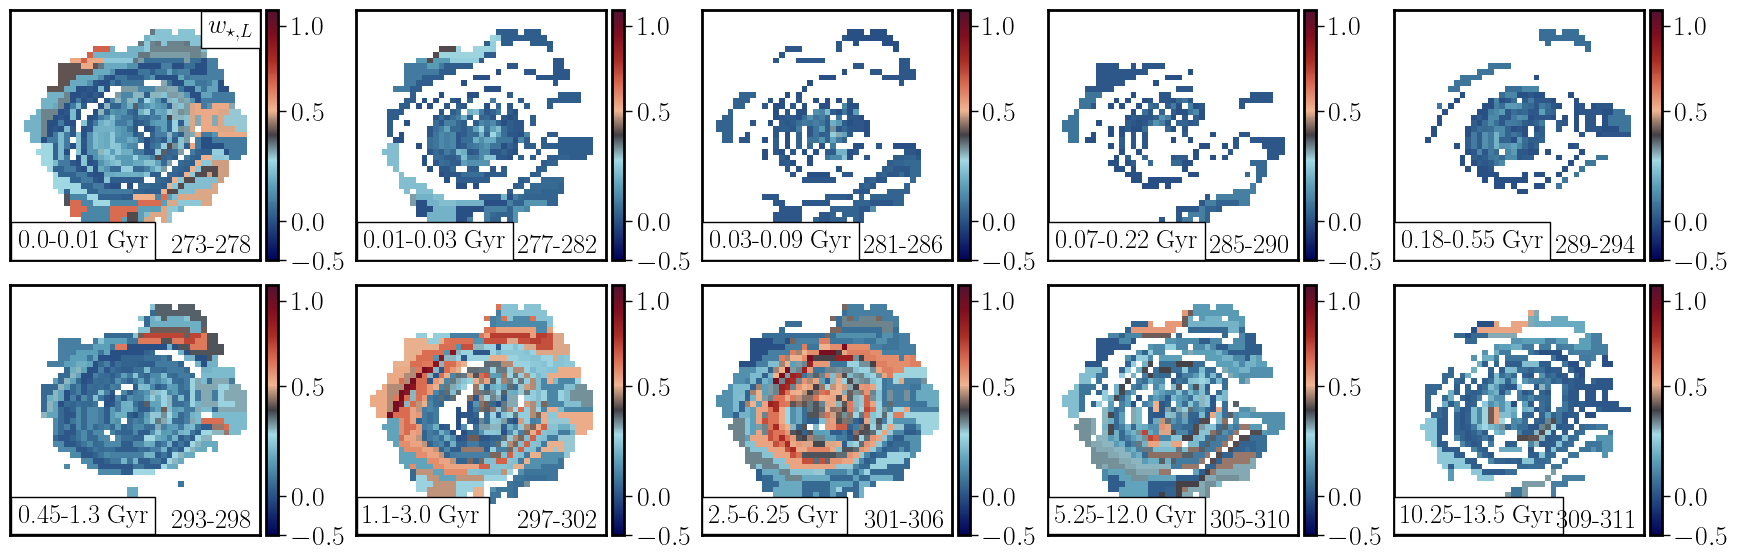

In [14]:
figname=name_now+".SFH"
SELECT_REG_data=Pipe3D_hdu[8].data
SFH_data=Pipe3D_hdu[2].data
SFH_hdr=Pipe3D_hdu[2].header
(nz,ny,nx)=SFH_data.shape
SFH_maps={}
SFH_labels={}
mark_labels={}
for i in arange(0,nz):
    key='DESC_'+str(i)
    SFH_labels[i]=SFH_hdr[key]
    mark_labels_now=SFH_labels[i]
    
    mark_labels_now=mark_labels_now.replace('Luminosity Fraction for age ','')
    mark_labels_now=mark_labels_now.replace(' SSP','')
    mark_labels[i]=mark_labels_now
#    print(i,mark_labels[i])
#    print(i,SFH_labels[i])

n_start=39*7
I_max=39
n_end=n_start+I_max
SFH_age=SFH_data[n_start:n_end,:,:]
(nz_age,ny_age,nx_age)=SFH_age.shape
print(nx_age,ny_age,nz_age)
n_bin=4
nz_bin=int(np.ceil(nz_age/n_bin))
mark_labels_bin={}
SFH_age_bin=np.zeros((nz_bin,ny_age,nx_age))
label_index={}
for i in arange(0,nz_bin):
    j_min=n_bin*i
    j_max=n_bin*(i+1)+1
    if (j_max>=I_max):
        j_max=I_max-1
    label_index[i]=str(j_min+n_start)+'-'+str(j_max+n_start)
    mark_labels_bin[i]=str(np.around(float(mark_labels[j_min+n_start]),2))+'-'+str(np.around(float(mark_labels[j_max+n_start]),2))+' Gyr'
#    mark_labels[j_min+n_start]+'-'+mark_labels[j_max+n_start]
    for j in arange(j_min,j_max):
        SFH_age_bin[i,:,:]=SFH_age_bin[i,:,:]+SFH_age[j,:,:]
#        print(i,mark_labels_bin[i])
#        print(i,j)

print(nz_bin)
NX=5
fig, axes = plt.subplots(int(np.ceil(nz_bin/NX)),NX, figsize=(int(3.6*NX),int(3*nz_bin/NX)))
#cmap='gist_stern_r'
#cmap='plasma'
#color_cm_now = vel_map()
color_cm_now = vel_map()
reverse=0
if (reverse==1):
    color_cm_now=color_cm_now.reversed()
cmap=cm.get_cmap(color_cm_now)



n_start=39*7
I_max=39
for I,ax in enumerate(axes.flat):
    if (I<nz_bin):
        indx=I+n_start
        key='DESC_'+str(indx)
        val=SFH_hdr[key]
#        print(key,val)
        image=SFH_age_bin[I,:,:]
        image = np.ma.masked_invalid(image)
        image=image*SELECT_REG_data
        image=image*1.0
        image=np.ma.masked_array(image,\
                                 (image==0.0))
        image=np.around(image,2)
        vmin=np.min(image)
        vmax=np.max(image)
        norm=colors.PowerNorm(gamma=0.75,vmin=-0.1,vmax=1.1)
        
        im_now=ax.imshow(image, interpolation='none',\
                         cmap=cmap, \
                         norm=norm)
        fig.colorbar(im_now, ax=ax, orientation='vertical',fraction=0.046, pad=0.02)
        ax.set_xlim(0,nx)
        ax.set_ylim(0,ny)
        ax.text(0.03*nx, 0.03*ny, mark_labels_bin[I], fontsize=19, \
                bbox={'facecolor': 'white', 'pad': 5},\
                va='bottom',ha='left')
        if (I==0):
            ax.text(0.97*nx, 0.97*ny, r'$w_{\star,L}$', fontsize=19,\
                    bbox={'facecolor': 'white', 'pad': 5},\
                    va='top',ha='right')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.text(0.97*nx, 0.1*ny, label_index[I], fontsize=19,\
                va='top',ha='right')        
    else:
        ax.set_visible(False)
    #ax.spines['left'].set_visible(False)
#    handles, labels = ax.get_legend_handles_labels()
#    ax.legend(handles, labels,loc=(0.05,0.75),frameon=True,handlelength=1.5)    
#fig.tight_layout()
fig.tight_layout(w_pad=0.15,h_pad=0.35)

fig.savefig(figname+".pdf", transparent=False, facecolor='white', edgecolor='white')#.pdf")

#    SSP_maps[val]=SSP_data[i,:,:]
#print(SSP_maps['pseudo V-band map'])

#print(nx)

44 44 7


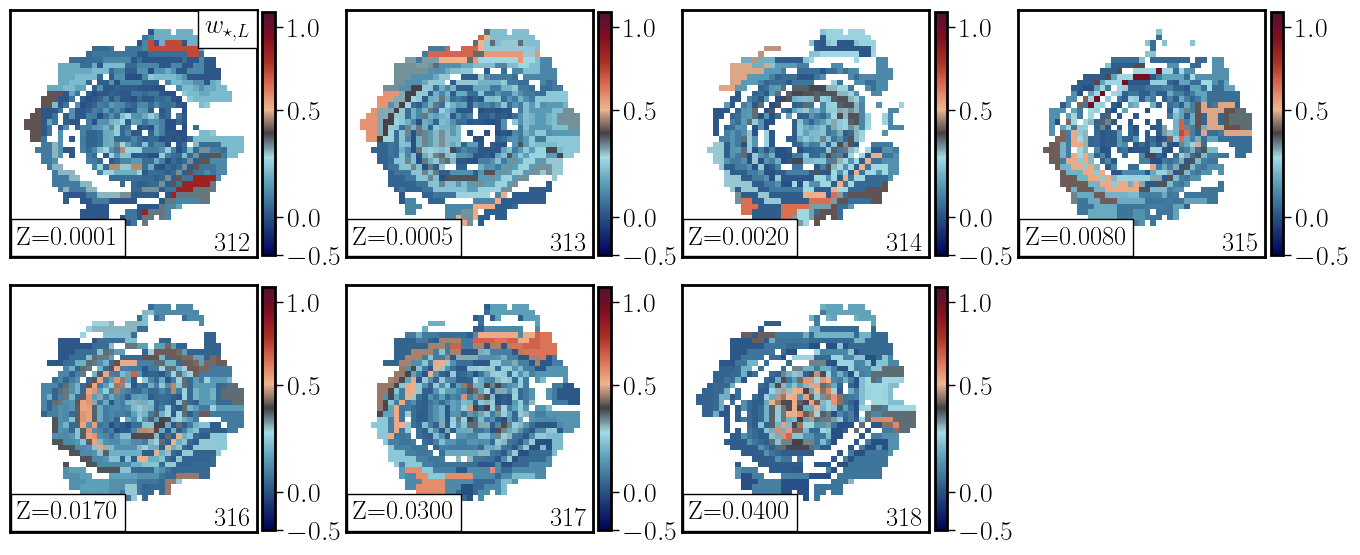

In [15]:
figname=name_now+".SFH_Z"
SELECT_REG_data=Pipe3D_hdu[8].data
SFH_data=Pipe3D_hdu[2].data
SFH_hdr=Pipe3D_hdu[2].header
(nz,ny,nx)=SFH_data.shape
SFH_maps={}
SFH_labels={}
mark_labels={}
#label_index={}
for i in arange(0,nz):
    key='DESC_'+str(i)
    SFH_labels[i]=SFH_hdr[key]
    mark_labels_now=SFH_labels[i]
    
    mark_labels_now=mark_labels_now.replace('Luminosity Fraction for age ','')
    mark_labels_now=mark_labels_now.replace('Luminosity Fraction for met ','')
    mark_labels_now=mark_labels_now.replace('Luminosity Fraction for age-met ','')
    mark_labels_now=mark_labels_now.replace(' SSP','')
    mark_labels[i]=mark_labels_now
#    label_index[I]
#    print(i,mark_labels[i])
#    print(i,SFH_labels[i])

n_start=39*7+39
I_max=7
n_end=n_start+I_max
SFH_met=SFH_data[n_start:n_end,:,:]
(nz_met,ny_met,nx_met)=SFH_met.shape
print(nx_met,ny_met,nz_met)

NY=2
NX=4
fig, axes = plt.subplots(NY,NX, figsize=(int(3.6*NX),int(3*NY)))
color_cm_now = vel_map()
reverse=0
if (reverse==1):
    color_cm_now=color_cm_now.reversed()
cmap=cm.get_cmap(color_cm_now)

for I,ax in enumerate(axes.flat):
    if (I<I_max):
        indx=I+n_start
        key='DESC_'+str(indx)
        val=SFH_hdr[key]
#        print(key,val)
        image=SFH_met[I,:,:]
        image = np.ma.masked_invalid(image)
        image=image*SELECT_REG_data
        image=image*1.0
        image=np.ma.masked_array(image,\
                                 (image==0.0))
        image=np.around(image,2)
        vmin=np.min(image)
        vmax=np.max(image)
        norm=colors.PowerNorm(gamma=0.75,\
                         vmin=-0.1,vmax=1.1)
        im_now=ax.imshow(image, interpolation='none',\
                         cmap=cmap, \
                         norm=norm)
        fig.colorbar(im_now, ax=ax, orientation='vertical',fraction=0.046, pad=0.02)
        ax.set_xlim(0,nx)
        ax.set_ylim(0,ny)
        ax.text(0.03*nx, 0.03*ny, 'Z='+mark_labels[I+n_start], fontsize=19, \
                bbox={'facecolor': 'white', 'pad': 5},\
                va='bottom',ha='left')
        if (I==0):
            ax.text(0.97*nx, 0.97*ny, r'$w_{\star,L}$', fontsize=19,\
                    bbox={'facecolor': 'white', 'pad': 5},\
                    va='top',ha='right')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.text(0.97*nx, 0.1*ny, str(I+n_start), fontsize=19,\
                va='top',ha='right')        
    else:
        ax.set_visible(False)
    #ax.spines['left'].set_visible(False)
#    handles, labels = ax.get_legend_handles_labels()
#    ax.legend(handles, labels,loc=(0.05,0.75),frameon=True,handlelength=1.5)    
#fig.tight_layout()
fig.tight_layout(w_pad=0.15,h_pad=0.35)

fig.savefig(figname+".pdf", transparent=False, facecolor='white', edgecolor='white')#.pdf")

#    SSP_maps[val]=SSP_data[i,:,:]
#print(SSP_maps['pseudo V-band map'])

#print(nx)

44 44 39
10


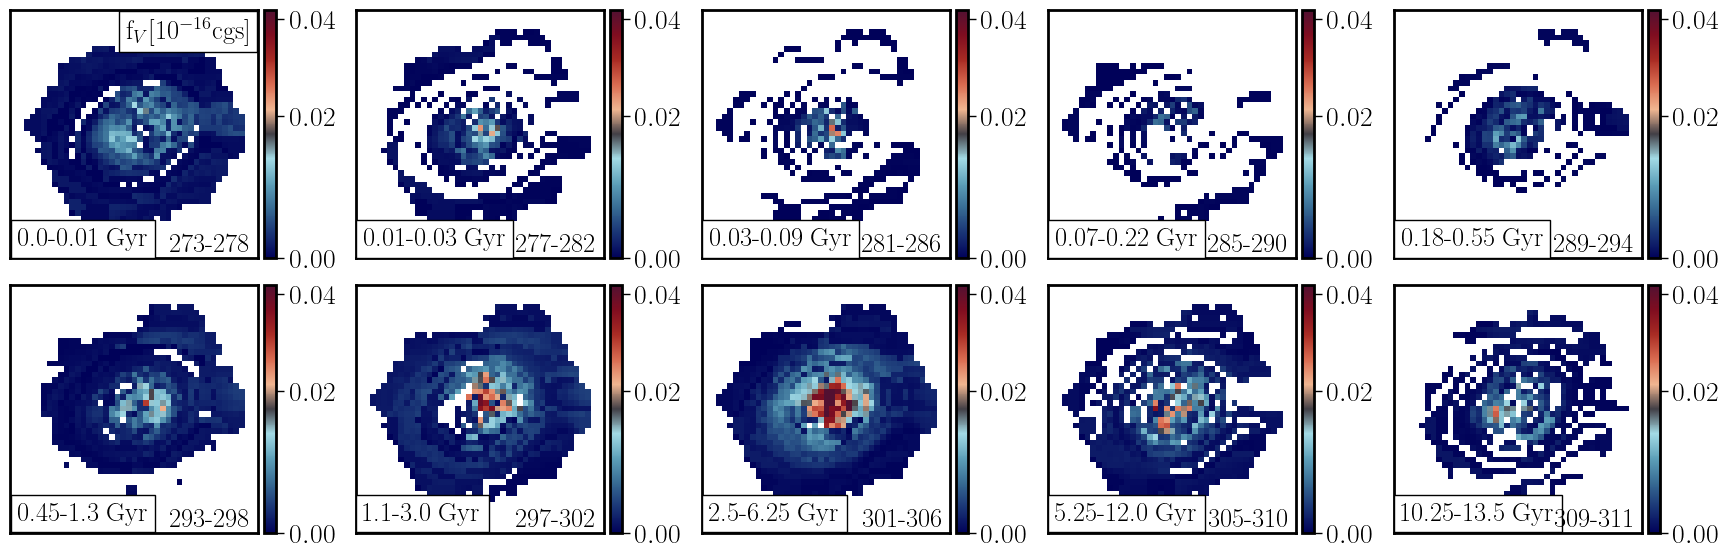

In [17]:
figname=name_now+".SFH_L"
SELECT_REG_data=Pipe3D_hdu[8].data
SFH_data=Pipe3D_hdu[2].data
SFH_hdr=Pipe3D_hdu[2].header
(nz,ny,nx)=SFH_data.shape
SFH_maps={}
SFH_labels={}
mark_labels={}
for i in arange(0,nz):
    key='DESC_'+str(i)
    SFH_labels[i]=SFH_hdr[key]
    mark_labels_now=SFH_labels[i]
    
    mark_labels_now=mark_labels_now.replace('Luminosity Fraction for age ','')
    mark_labels_now=mark_labels_now.replace(' SSP','')
    mark_labels[i]=mark_labels_now
#    print(i,mark_labels[i])
#    print(i,SFH_labels[i])

n_start=39*7
I_max=39
n_end=n_start+I_max
SFH_age=SFH_data[n_start:n_end,:,:]
(nz_age,ny_age,nx_age)=SFH_age.shape
print(nx_age,ny_age,nz_age)
n_bin=4
nz_bin=int(np.ceil(nz_age/n_bin))
mark_labels_bin={}
SFH_age_bin=np.zeros((nz_bin,ny_age,nx_age))
label_index={}
for i in arange(0,nz_bin):
    j_min=n_bin*i
    j_max=n_bin*(i+1)+1
    if (j_max>=I_max):
        j_max=I_max-1
    label_index[i]=str(j_min+n_start)+'-'+str(j_max+n_start)
    mark_labels_bin[i]=str(np.around(float(mark_labels[j_min+n_start]),2))+'-'+str(np.around(float(mark_labels[j_max+n_start]),2))+' Gyr'
#    mark_labels[j_min+n_start]+'-'+mark_labels[j_max+n_start]
    for j in arange(j_min,j_max):
        SFH_age_bin[i,:,:]=SFH_age_bin[i,:,:]+SFH_age[j,:,:]*SSP_data[0,:,:]*SSP_data[2,:,:]
#        print(i,mark_labels_bin[i])
#        print(i,j)

print(nz_bin)
NX=5
fig, axes = plt.subplots(int(np.ceil(nz_bin/NX)),NX, figsize=(int(3.6*NX),int(3*nz_bin/NX)))
#cmap='gist_stern_r'
#cmap='plasma'
#color_cm_now = vel_map()
color_cm_now = vel_map()
reverse=0
if (reverse==1):
    color_cm_now=color_cm_now.reversed()
cmap=cm.get_cmap(color_cm_now)



n_start=39*7
I_max=39
for I,ax in enumerate(axes.flat):
    if (I<nz_bin):
        indx=I+n_start
        key='DESC_'+str(indx)
        val=SFH_hdr[key]
#        print(key,val)
        image=SFH_age_bin[I,:,:]
        image = np.ma.masked_invalid(image)
        image=image*SELECT_REG_data
        image=image*1.0
        image=np.ma.masked_array(image,\
                                 (image==0.0))
        #image=np.around(image,2)
        vmin=np.min(SSP_data[0,:,:]*0.5)
        vmax=np.max(SSP_data[0,:,:]*0.5)
        norm=colors.PowerNorm(gamma=0.75,\
                         vmin=vmin,vmax=vmax)
        im_now=ax.imshow(image, interpolation='none',\
                         cmap=cmap, \
                         norm=norm)
        fig.colorbar(im_now, ax=ax, orientation='vertical',fraction=0.046, pad=0.02)
        ax.set_xlim(0,nx)
        ax.set_ylim(0,ny)
        ax.text(0.03*nx, 0.03*ny, mark_labels_bin[I], fontsize=19, bbox={'facecolor': 'white', 'pad': 5},\
                va='bottom',ha='left')
        if (I==0):
            ax.text(0.97*nx, 0.97*ny, r'f$_V$[10$^{-16}$cgs]', fontsize=19, \
                    bbox={'facecolor': 'white', 'pad': 5},\
                    va='top',ha='right')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.text(0.97*nx, 0.1*ny, label_index[I], fontsize=19,\
                va='top',ha='right')
    else:
        ax.set_visible(False)
    #ax.spines['left'].set_visible(False)
#    handles, labels = ax.get_legend_handles_labels()
#    ax.legend(handles, labels,loc=(0.05,0.75),frameon=True,handlelength=1.5)    
#fig.tight_layout()
fig.tight_layout(w_pad=0.15,h_pad=0.35)

fig.savefig(figname+".pdf", transparent=False, facecolor='white', edgecolor='white')#.pdf")

#    SSP_maps[val]=SSP_data[i,:,:]
#print(SSP_maps['pseudo V-band map'])

#print(nx)

In [19]:
#catalog_file="tables/SDSS17Pipe3D_v3_1_1.fits"
catalog_hdu=hdu
#print(catalog_hdu.info())
#catalog_tab = Table.read(catalog_hdu[1].data,format='fits')
ssp_data=catalog_hdu[2].data
ssp_hdr=catalog_hdu[2].header
(ny_ssp,nx_ssp)=ssp_data.shape
ssp_norm=[]
ssp_name=[]
ssp_age_met=[]
ssp_age=[]
ssp_met=[]
norm_age={}
norm_met={}
for i in arange(0,ny_ssp):
#    j=i+1
    key='NORM'+str(i)
    norm_now=ssp_hdr[key]
    ssp_norm.append(norm_now)
    key='NAME'+str(i)
    ssp_name_now=ssp_hdr[key]
    ssp_name.append(ssp_hdr[key])
    age_met=ssp_name_now.replace("spec_ssp_","")
    age_met=age_met.replace(".spec","")
    age_met=age_met.replace("_z",",0.")
    ssp_age_met.append(age_met)
    ssp_vals=age_met.split(",")
    age_now=float(ssp_vals[0])
    met_now=float(ssp_vals[1])
    try:
        norm_age[age_now]=norm_age[age_now]+norm_now
    except:        
        norm_age[age_now]=norm_now
    try:
        norm_met[met_now]=norm_met[met_now]+norm_now
    except:        
        norm_met[met_now]=norm_now
        

    ssp_age.append(age_now)
    ssp_met.append(met_now)
#    print(age_now,met_now)
#    print(i,ssp_norm[i])
ssp_norm=np.array(ssp_norm)
ssp_name=np.array(ssp_name)
ssp_age_met=np.array(ssp_age_met)
ssp_age=np.array(ssp_age,float)
ssp_met=np.array(ssp_met,float)
ssp_age=np.unique(ssp_age)
ssp_met=np.unique(ssp_met)
for key in norm_age:
    norm_age[key]=norm_age[key]/len(ssp_met)
for key in norm_met:
    norm_met[key]=norm_met[key]/len(ssp_age)

norm_age_sort={}
norm_met_sort={}
ssp_age=np.sort(ssp_age)
ssp_met=np.sort(ssp_met)
for key in ssp_age:
    norm_age_sort[key]=norm_age[key]
for key in ssp_met:
    norm_met_sort[key]=norm_met[key]

print(norm_age_sort)
print(norm_met_sort)

print(ssp_norm.shape)
#    mark_labels_now=SFH_labels[i]
#plt.imshow(ssp_data)


{0.001: 0.006541014285714285, 0.0023: 0.010148257142857142, 0.0038: 0.022763142857142853, 0.00575: 0.011208357142857143, 0.008: 0.005588271428571429, 0.0115: 0.004231214285714286, 0.015: 0.003016471428571428, 0.02: 0.0026089999999999998, 0.026: 0.002347214285714286, 0.033: 0.002120457142857143, 0.0425: 0.0018480285714285714, 0.0535: 0.0015954142857142856, 0.07: 0.0013552142857142858, 0.09: 0.0011759, 0.11: 0.0010509157142857143, 0.14: 0.0009121357142857142, 0.18: 0.0007814828571428572, 0.225: 0.0006836342857142857, 0.275: 0.0006017442857142858, 0.35: 0.0005100528571428572, 0.45: 0.0004235842857142858, 0.55: 0.0003648557142857142, 0.65: 0.00031986857142857146, 0.85: 0.00025538000000000004, 1.1: 0.00020774714285714285, 1.3: 0.0001854442857142857, 1.6: 0.0001636707142857143, 2.0: 0.00011986042857142856, 2.5: 9.741857142857143e-05, 3.0: 8.525528571428571e-05, 3.75: 6.762457142857143e-05, 4.5: 5.680942857142857e-05, 5.25: 4.905471428571428e-05, 6.25: 4.2136571428571424e-05, 7.5: 3.588114285

In [20]:
i_start_age=len(ssp_age)*len(ssp_met) 
print(i_start_age)
for i,key in enumerate(ssp_age):
    print(key,mark_labels[i_start_age+i])


273
0.001 0.0010
0.0023 0.0023
0.0038 0.0038
0.00575 0.0057
0.008 0.0080
0.0115 0.0115
0.015 0.0150
0.02 0.0200
0.026 0.0260
0.033 0.0330
0.0425 0.0425
0.0535 0.0535
0.07 0.0700
0.09 0.0900
0.11 0.1100
0.14 0.1400
0.18 0.1800
0.225 0.2250
0.275 0.2750
0.35 0.3500
0.45 0.4500
0.55 0.5500
0.65 0.6500
0.85 0.8500
1.1 1.1000
1.3 1.3000
1.6 1.6000
2.0 2.0000
2.5 2.5000
3.0 3.0000
3.75 3.7500
4.5 4.5000
5.25 5.2500
6.25 6.2500
7.5 7.5000
8.5 8.5000
10.25 10.2500
12.0 12.0000
13.5 13.5000


44 44 39
10


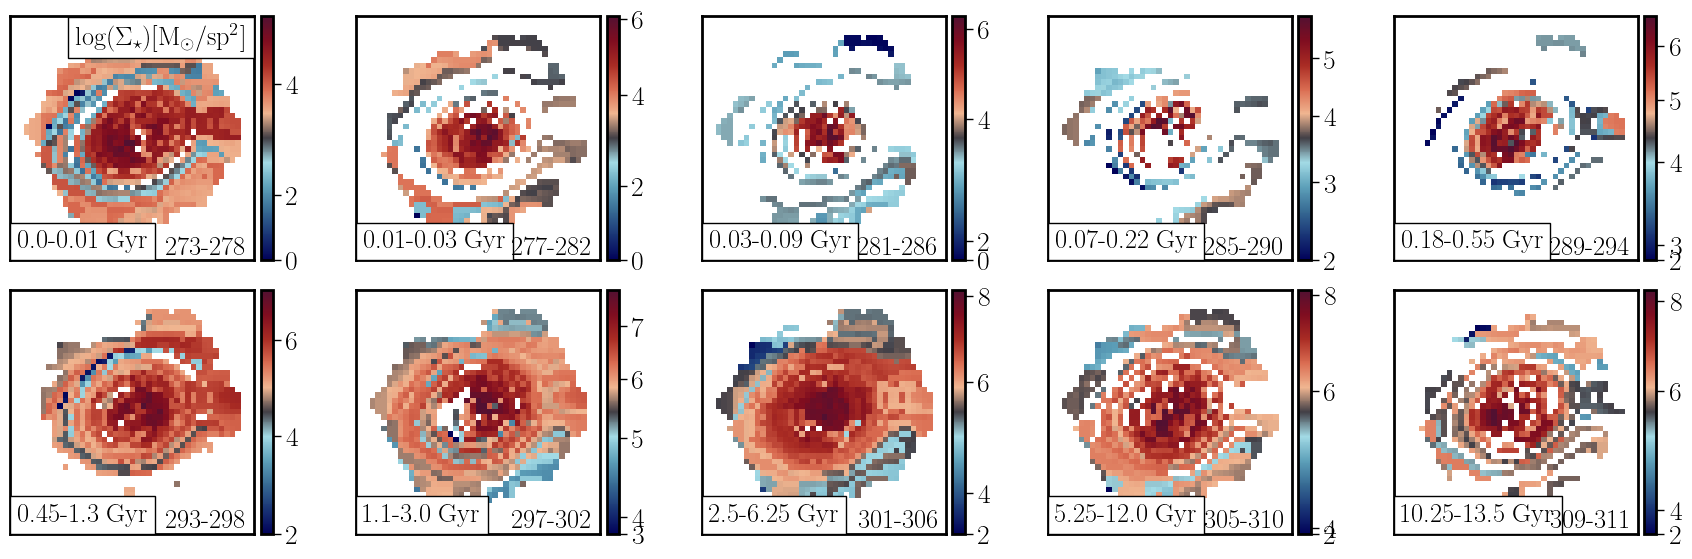

In [21]:
figname=name_now+".SFH_M"
SELECT_REG_data=Pipe3D_hdu[8].data
SFH_data=Pipe3D_hdu[2].data
SFH_hdr=Pipe3D_hdu[2].header
(nz,ny,nx)=SFH_data.shape
SFH_maps={}
SFH_labels={}
mark_labels={}
for i in arange(0,nz):
    key='DESC_'+str(i)
    SFH_labels[i]=SFH_hdr[key]
    mark_labels_now=SFH_labels[i]
    
    mark_labels_now=mark_labels_now.replace('Luminosity Fraction for age ','')
    mark_labels_now=mark_labels_now.replace(' SSP','')
    mark_labels[i]=mark_labels_now
#    print(i,mark_labels[i])
#    print(i,SFH_labels[i])

n_start=39*7
I_max=39
n_end=n_start+I_max
SFH_age=SFH_data[n_start:n_end,:,:]
#ssp_norm_age=ssp_norm[n_start:n_end]
#print(ssp_norm_age.shape,n_start,n_end)
(nz_age,ny_age,nx_age)=SFH_age.shape
print(nx_age,ny_age,nz_age)
sum_ssp_norm=np.zeros((ny_age,nx_age))
img_ones=np.ones((ny_age,nx_age))
ages=[]
for j,key in enumerate(ssp_age):
    sum_ssp_norm=sum_ssp_norm+img_ones*SFH_age[j,:,:]/norm_age_sort[key]
    ages.append(key)
ages=np.array(ages)
    
n_bin=4
nz_bin=int(np.ceil(nz_age/n_bin))
mark_labels_bin={}
SFH_age_bin=np.zeros((nz_bin,ny_age,nx_age))

label_index={}
for i in arange(0,nz_bin):
    j_min=n_bin*i
    j_max=n_bin*(i+1)+1
    if (j_max>=I_max):
        j_max=I_max-1
    label_index[i]=str(j_min+n_start)+'-'+str(j_max+n_start)
    mark_labels_bin[i]=str(np.around(float(mark_labels[j_min+n_start]),2))+'-'+str(np.around(float(mark_labels[j_max+n_start]),2))+' Gyr'
#    mark_labels[j_min+n_start]+'-'+mark_labels[j_max+n_start]
    for j in arange(j_min,j_max):
        key=ages[j]
        SFH_age_bin[i,:,:]=SFH_age_bin[i,:,:]+\
        SFH_age[j,:,:]*10**(SSP_data[18,:,:])*SSP_data[2,:,:]/norm_age_sort[key]
    SFH_age_bin[i,:,:]=np.log10(SFH_age_bin[i,:,:]/sum_ssp_norm)
#        print(i,mark_labels_bin[i])
#        print(i,j)

print(nz_bin)
NX=5
fig, axes = plt.subplots(int(np.ceil(nz_bin/NX)),NX, figsize=(int(3.6*NX),int(3*nz_bin/NX)))
#cmap='gist_stern_r'
#cmap='plasma'
#color_cm_now = vel_map()
color_cm_now = vel_map()
reverse=0
if (reverse==1):
    color_cm_now=color_cm_now.reversed()
cmap=cm.get_cmap(color_cm_now)



n_start=39*7
I_max=39
for I,ax in enumerate(axes.flat):
    if (I<nz_bin):
        indx=I+n_start
        key='DESC_'+str(indx)
        val=SFH_hdr[key]
#        print(key,val)
        image=SFH_age_bin[I,:,:]
        image = np.ma.masked_invalid(image)
        image=image*SELECT_REG_data
        image=image*1.0
        image=np.ma.masked_array(image,\
                                 (image==0.0))
        image=np.around(image,2)
        vmin=np.nanmin(image)
        vmax=np.nanmax(image)
#        vmin=np.nanmin(SSP_data[18,:,:])
#        vmax=np.nanmax(SSP_data[18,:,:])
#        print(I,vmin,vmax)
        norm=colors.PowerNorm(gamma=0.75,\
                         vmin=vmin,vmax=vmax)
        im_now=ax.imshow(image, interpolation='none',\
                         cmap=cmap, \
                         norm=norm)
        fig.colorbar(im_now, ax=ax, orientation='vertical',fraction=0.046, pad=0.02)
        ax.set_xlim(0,nx)
        ax.set_ylim(0,ny)
        ax.text(0.03*nx, 0.03*ny, mark_labels_bin[I], fontsize=19, bbox={'facecolor': 'white', 'pad': 5},\
                va='bottom',ha='left')
        if (I==0):
            ax.text(0.97*nx, 0.97*ny, r'log($\Sigma_\star$)[M$_\odot$/sp$^2$]', fontsize=19, bbox={'facecolor': 'white', 'pad': 5},\
                    va='top',ha='right')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.text(0.97*nx, 0.1*ny, label_index[I], fontsize=19,\
                va='top',ha='right')
        
    else:
        ax.set_visible(False)
                
    #ax.spines['left'].set_visible(False)
#    handles, labels = ax.get_legend_handles_labels()
#    ax.legend(handles, labels,loc=(0.05,0.75),frameon=True,handlelength=1.5)    
#fig.tight_layout()
fig.tight_layout(w_pad=0.15,h_pad=0.35)

fig.savefig(figname+".pdf", transparent=False, facecolor='white', edgecolor='white')#.pdf")

#    SSP_maps[val]=SSP_data[i,:,:]
#print(SSP_maps['pseudo V-band map'])

#print(nx)

44 44 39


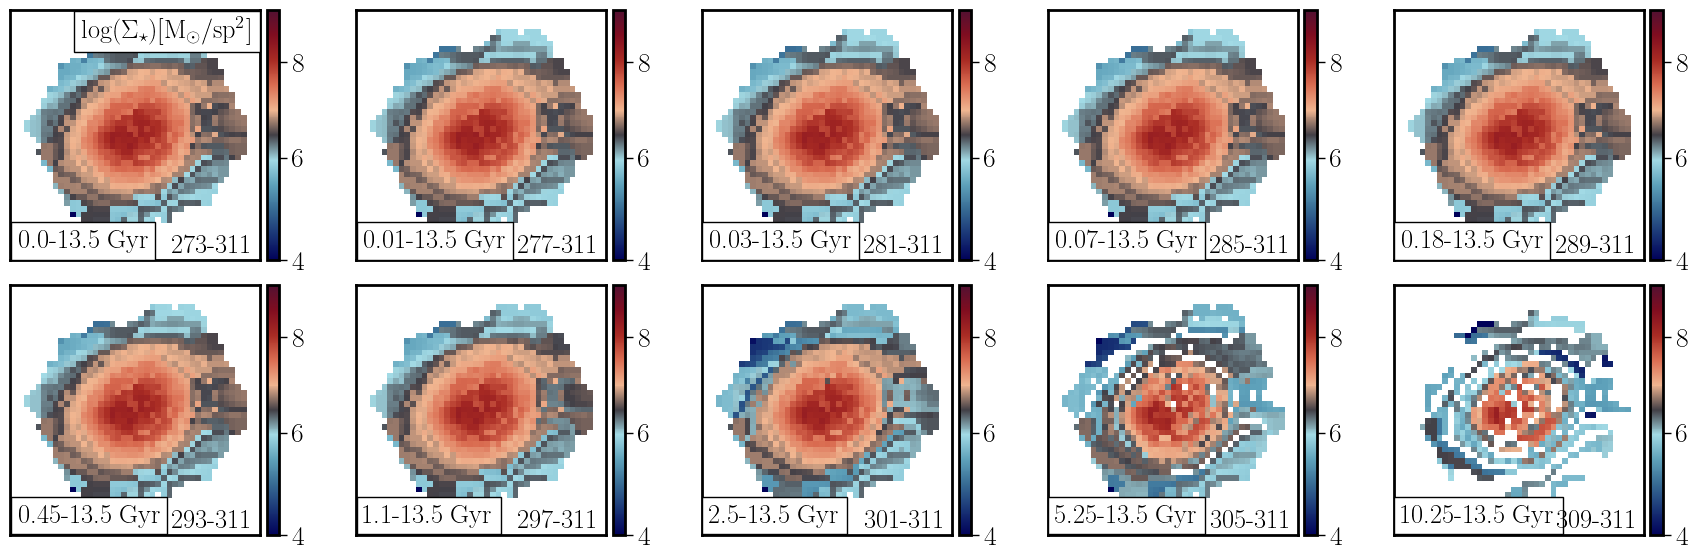

In [22]:
figname=name_now+".SFH_CM"
SELECT_REG_data=Pipe3D_hdu[8].data
SFH_data=Pipe3D_hdu[2].data
SFH_hdr=Pipe3D_hdu[2].header
(nz,ny,nx)=SFH_data.shape
SFH_maps={}
SFH_labels={}
mark_labels={}
for i in arange(0,nz):
    key='DESC_'+str(i)
    SFH_labels[i]=SFH_hdr[key]
    mark_labels_now=SFH_labels[i]
    
    mark_labels_now=mark_labels_now.replace('Luminosity Fraction for age ','')
    mark_labels_now=mark_labels_now.replace(' SSP','')
    mark_labels[i]=mark_labels_now
#    print(i,mark_labels[i])
#    print(i,SFH_labels[i])

n_start=39*7
I_max=39
n_end=n_start+I_max
SFH_age=SFH_data[n_start:n_end,:,:]
(nz_age,ny_age,nx_age)=SFH_age.shape
print(nx_age,ny_age,nz_age)
n_bin=4
nz_bin=int(np.ceil(nz_age/n_bin))
mark_labels_bin={}
SFH_age_bin=np.zeros((nz_bin,ny_age,nx_age))
label_index={}
for i in arange(0,nz_bin):
    j_min=n_bin*i
    j_max=I_max-1#n_bin*(i+1)+1
    #if (j_max>=I_max):
    #    j_max=I_max-1
    label_index[i]=str(j_min+n_start)+'-'+str(j_max+n_start)
    mark_labels_bin[i]=str(np.around(float(mark_labels[j_min+n_start]),2))+'-'+str(np.around(float(mark_labels[j_max+n_start]),2))+' Gyr'
#    mark_labels[j_min+n_start]+'-'+mark_labels[j_max+n_start]
    for j in arange(j_min,j_max):
        key=ages[j]
        SFH_age_bin[i,:,:]=SFH_age_bin[i,:,:]+\
        SFH_age[j,:,:]*10**(SSP_data[18,:,:])*SSP_data[2,:,:]/norm_age_sort[key]
    SFH_age_bin[i,:,:]=np.log10(SFH_age_bin[i,:,:]/sum_ssp_norm)
#    SFH_age_bin[i,:,:]=np.log10(SFH_age_bin[i,:,:])
#    print(i,mark_labels_bin[i])
#        print(i,j)

#print(nz_bin)
NX=5
fig, axes = plt.subplots(int(np.ceil(nz_bin/NX)),NX, figsize=(int(3.6*NX),int(3*nz_bin/NX)))
#cmap='gist_stern_r'
#cmap='plasma'
#color_cm_now = vel_map()
color_cm_now = vel_map()
reverse=0
if (reverse==1):
    color_cm_now=color_cm_now.reversed()
cmap=cm.get_cmap(color_cm_now)



n_start=39*7
I_max=39
for I,ax in enumerate(axes.flat):
    if (I<nz_bin):
        indx=I+n_start
        key='DESC_'+str(indx)
        val=SFH_hdr[key]
#        print(key,val)
        image=SFH_age_bin[I,:,:]
        image = np.ma.masked_invalid(image)
        image=image*SELECT_REG_data
        image=image*1.0
        image=np.ma.masked_array(image,\
                                 (image==0.0))
        image=np.around(image,2)
        vmin=np.nanmin(SSP_data[18,:,:][SSP_data[18,:,:]>0])
        vmax=np.nanmax(SSP_data[18,:,:][SSP_data[18,:,:]>0])
#        vmin=np.nanmin(image[image>0])
#        vmax=np.nanmax(image[image>0])
#        print(I,vmin,vmax)
        norm=colors.PowerNorm(gamma=0.75,\
                         vmin=vmin*0.9,vmax=vmax*1.1)
        im_now=ax.imshow(image, interpolation='none',\
                         cmap=cmap, \
                         norm=norm)
        fig.colorbar(im_now, ax=ax, orientation='vertical',fraction=0.046, pad=0.02)
        ax.set_xlim(0,nx)
        ax.set_ylim(0,ny)
        ax.text(0.03*nx, 0.03*ny, mark_labels_bin[I], fontsize=19, bbox={'facecolor': 'white', 'pad': 5},\
                va='bottom',ha='left')
        if (I==0):
            ax.text(0.97*nx, 0.97*ny, r'log($\Sigma_\star$)[M$_\odot$/sp$^2$]', fontsize=19, bbox={'facecolor': 'white', 'pad': 5},\
                    va='top',ha='right')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.text(0.97*nx, 0.1*ny, label_index[I], fontsize=19,\
                va='top',ha='right')
    else:
        ax.set_visible(False)
        
    #ax.spines['left'].set_visible(False)
#    handles, labels = ax.get_legend_handles_labels()
#    ax.legend(handles, labels,loc=(0.05,0.75),frameon=True,handlelength=1.5)    
#fig.tight_layout()
fig.tight_layout(w_pad=0.15,h_pad=0.35)

fig.savefig(figname+".pdf", transparent=False, facecolor='white', edgecolor='white')#.pdf")

#    SSP_maps[val]=SSP_data[i,:,:]
#print(SSP_maps['pseudo V-band map'])

#print(nx)

44 44 39


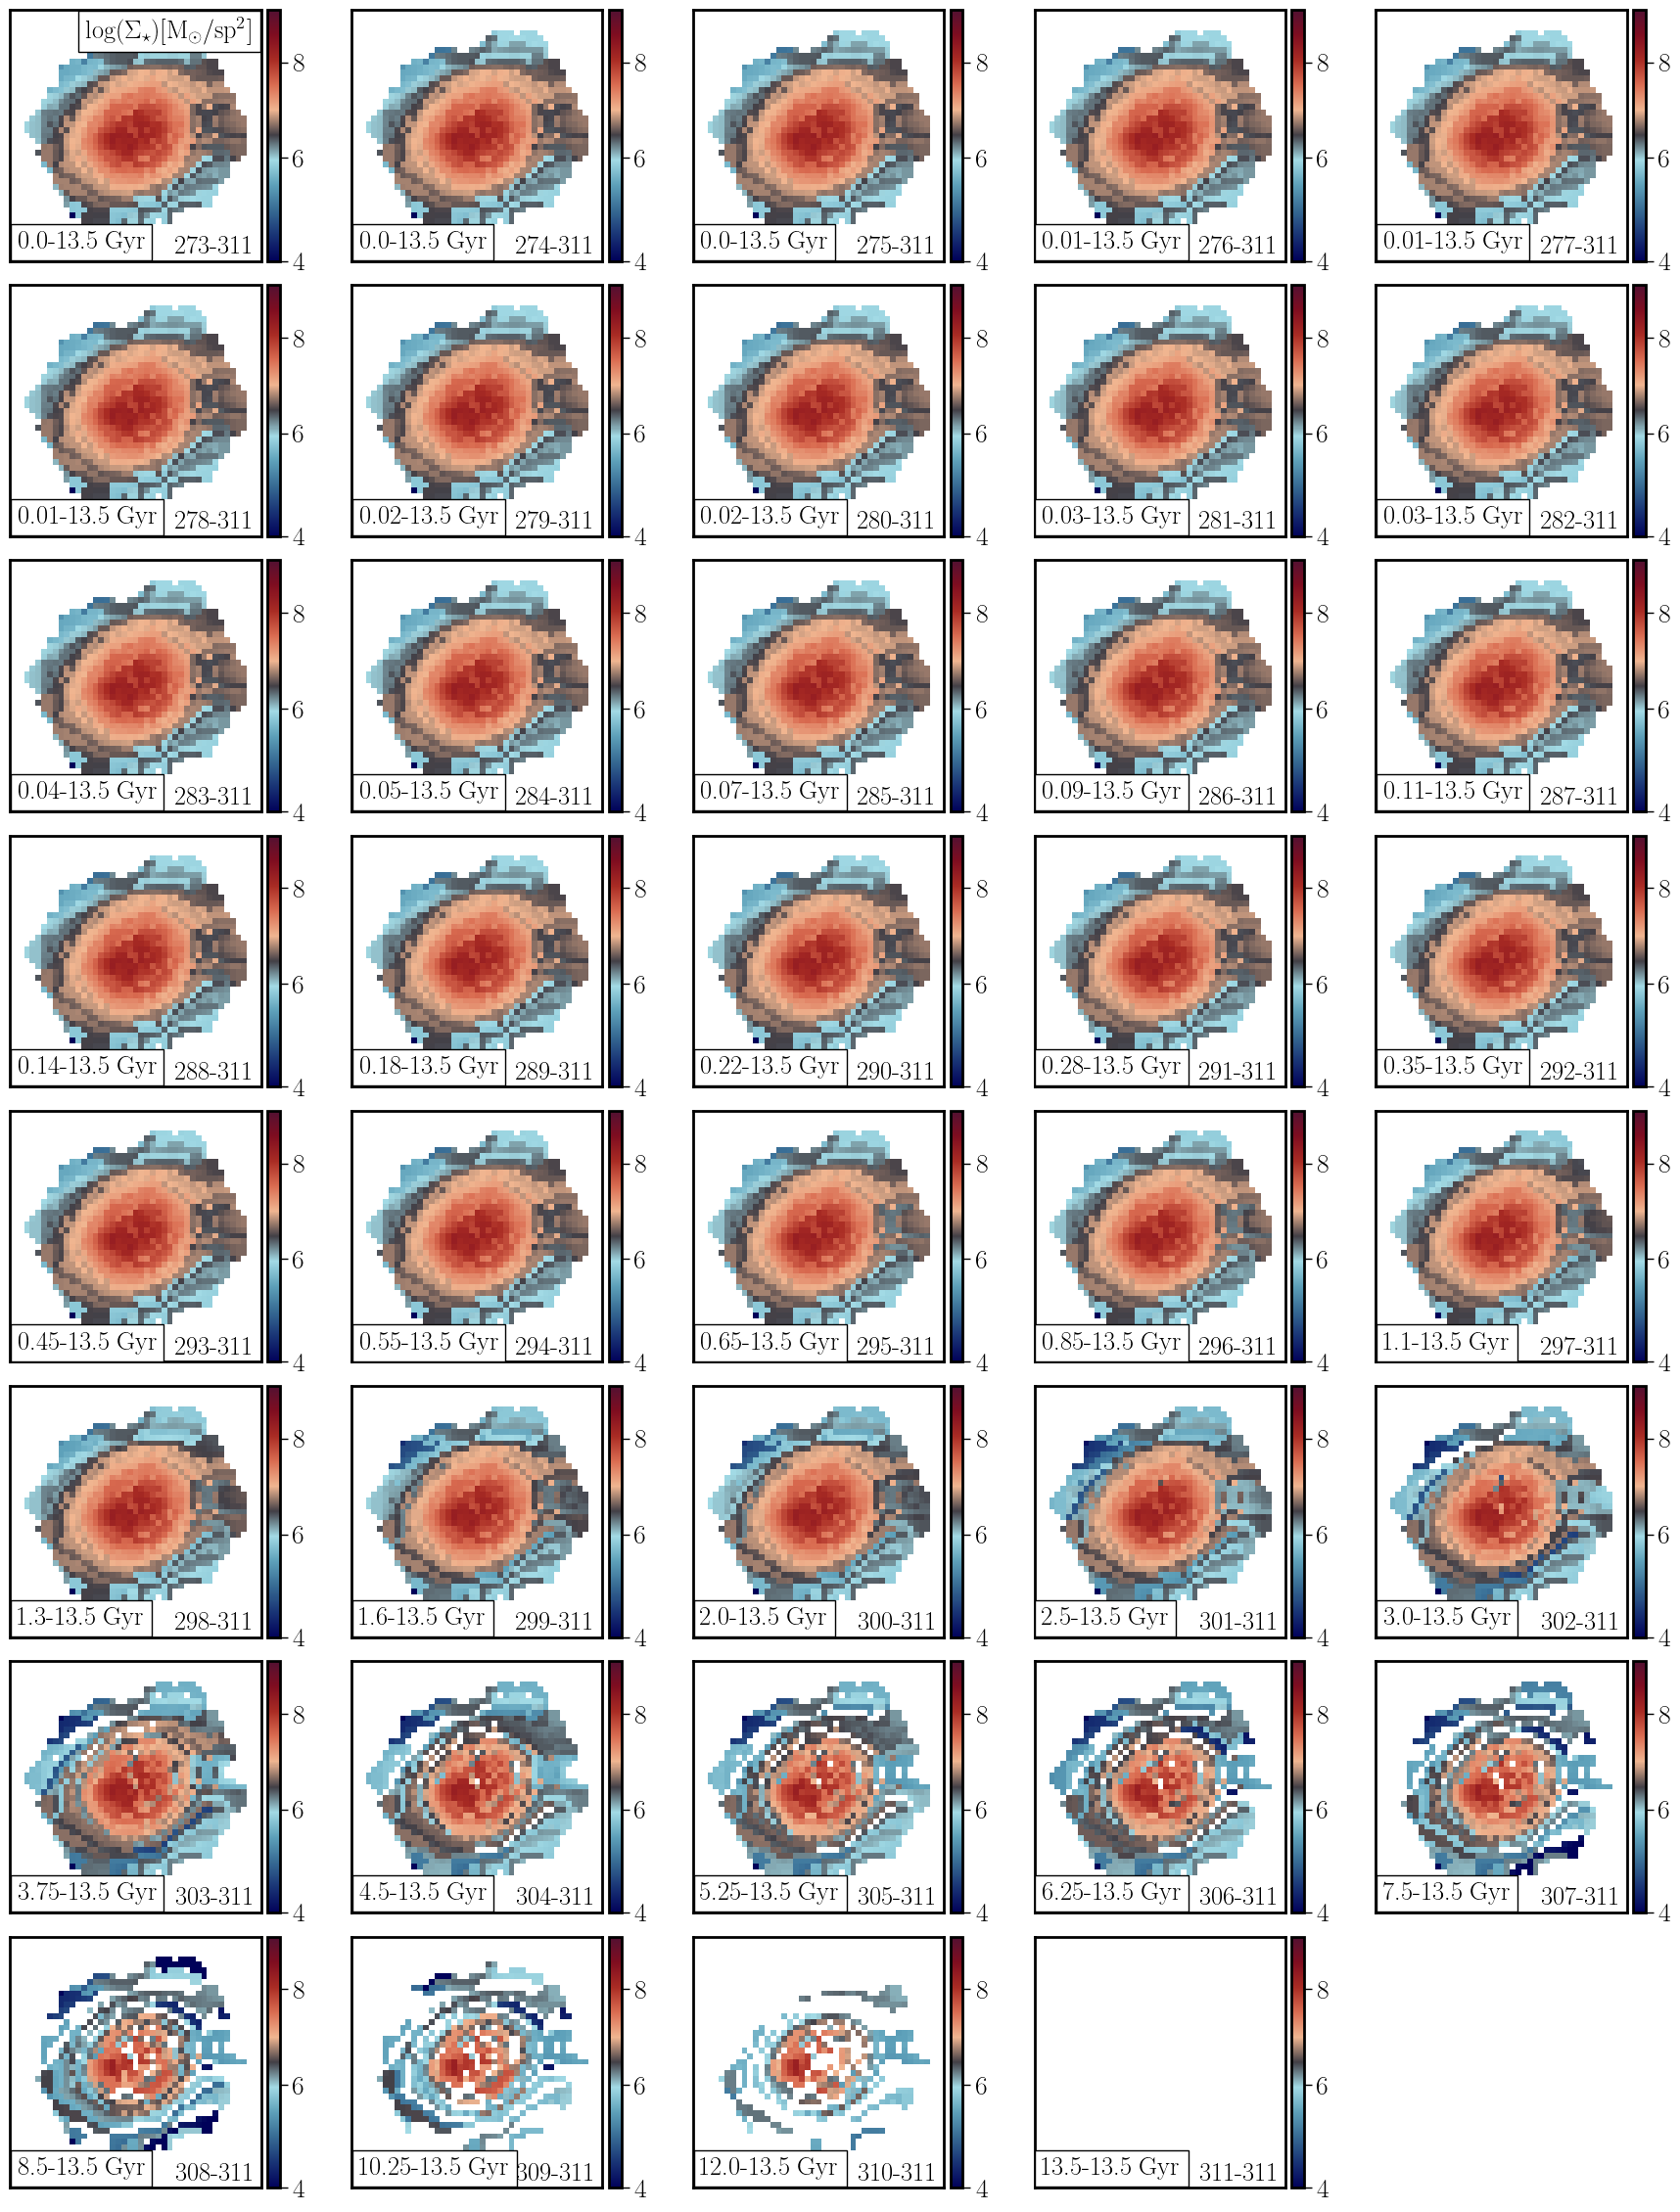

In [23]:
figname=name_now+".SFH_CM_ALL"
SELECT_REG_data=Pipe3D_hdu[8].data
SFH_data=Pipe3D_hdu[2].data
SFH_hdr=Pipe3D_hdu[2].header
(nz,ny,nx)=SFH_data.shape
SFH_maps={}
SFH_labels={}
mark_labels={}
for i in arange(0,nz):
    key='DESC_'+str(i)
    SFH_labels[i]=SFH_hdr[key]
    mark_labels_now=SFH_labels[i]
    
    mark_labels_now=mark_labels_now.replace('Luminosity Fraction for age ','')
    mark_labels_now=mark_labels_now.replace(' SSP','')
    mark_labels[i]=mark_labels_now
#    print(i,mark_labels[i])
#    print(i,SFH_labels[i])

n_start=39*7
I_max=39
n_end=n_start+I_max
SFH_age=SFH_data[n_start:n_end,:,:]
(nz_age,ny_age,nx_age)=SFH_age.shape
print(nx_age,ny_age,nz_age)
n_bin=1
nz_bin=int(np.ceil(nz_age/n_bin))
mark_labels_bin={}
SFH_age_bin=np.zeros((nz_bin,ny_age,nx_age))
label_index={}
for i in arange(0,nz_bin):
    j_min=n_bin*i
    j_max=I_max-1#n_bin*(i+1)+1
    #if (j_max>=I_max):
    #    j_max=I_max-1
    label_index[i]=str(j_min+n_start)+'-'+str(j_max+n_start)
    mark_labels_bin[i]=str(np.around(float(mark_labels[j_min+n_start]),2))+'-'+str(np.around(float(mark_labels[j_max+n_start]),2))+' Gyr'
#    mark_labels[j_min+n_start]+'-'+mark_labels[j_max+n_start]
    for j in arange(j_min,j_max):
        key=ages[j]
        SFH_age_bin[i,:,:]=SFH_age_bin[i,:,:]+\
        SFH_age[j,:,:]*10**(SSP_data[18,:,:])*SSP_data[2,:,:]/norm_age_sort[key]
    SFH_age_bin[i,:,:]=np.log10(SFH_age_bin[i,:,:]/sum_ssp_norm)
#    SFH_age_bin[i,:,:]=np.log10(SFH_age_bin[i,:,:])
#    print(i,mark_labels_bin[i])
#        print(i,j)

#print(nz_bin)
NX=5
fig, axes = plt.subplots(int(np.ceil(nz_bin/NX)),NX, figsize=(int(3.6*NX),int(3*nz_bin/NX)))
#cmap='gist_stern_r'
#cmap='plasma'
#color_cm_now = vel_map()
color_cm_now = vel_map()
reverse=0
if (reverse==1):
    color_cm_now=color_cm_now.reversed()
cmap=cm.get_cmap(color_cm_now)



n_start=39*7
I_max=39
#SFH_CM=np.zeros(nz_bin,ny,nx)
for I,ax in enumerate(axes.flat):
    if (I<nz_bin):
        indx=I+n_start
        key='DESC_'+str(indx)
        val=SFH_hdr[key]
#        print(key,val)
        image=SFH_age_bin[I,:,:]
        image = np.ma.masked_invalid(image)
        image=image*SELECT_REG_data
        image=image*1.0
        image=np.ma.masked_array(image,\
                                 (image==0.0))
        image=np.around(image,2)
        vmin=np.nanmin(SSP_data[18,:,:][SSP_data[18,:,:]>0])
        vmax=np.nanmax(SSP_data[18,:,:][SSP_data[18,:,:]>0])
#        vmin=np.nanmin(image[image>0])
#        vmax=np.nanmax(image[image>0])
#        print(I,vmin,vmax)
        norm=colors.PowerNorm(gamma=0.75,\
                         vmin=vmin*0.9,vmax=vmax*1.1)
        im_now=ax.imshow(image, interpolation='none',\
                         cmap=cmap, \
                         norm=norm)
        fig.colorbar(im_now, ax=ax, orientation='vertical',fraction=0.046, pad=0.02)
        ax.set_xlim(0,nx)
        ax.set_ylim(0,ny)
        ax.text(0.03*nx, 0.03*ny, mark_labels_bin[I], fontsize=19, bbox={'facecolor': 'white', 'pad': 5},\
                va='bottom',ha='left')
        if (I==0):
            ax.text(0.97*nx, 0.97*ny, r'log($\Sigma_\star$)[M$_\odot$/sp$^2$]', fontsize=19, bbox={'facecolor': 'white', 'pad': 5},\
                    va='top',ha='right')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.text(0.97*nx, 0.1*ny, label_index[I], fontsize=19,\
                va='top',ha='right')
    else:
        ax.set_visible(False)
        
    #ax.spines['left'].set_visible(False)
#    handles, labels = ax.get_legend_handles_labels()
#    ax.legend(handles, labels,loc=(0.05,0.75),frameon=True,handlelength=1.5)    
#fig.tight_layout()
fig.tight_layout(w_pad=0.15,h_pad=0.35)

fig.savefig(figname+".pdf", transparent=False, facecolor='white', edgecolor='white')#.pdf")

#    SSP_maps[val]=SSP_data[i,:,:]
#print(SSP_maps['pseudo V-band map'])

#print(nx)

In [26]:
tab_now=tab[tab['name']==name_now]
Re_kpc=tab_now['Re_kpc']
Re_arc=tab_now['Re_arc']
print(Re_kpc,Re_arc)
kpc_to_arc=Re_kpc/Re_arc
kpc_to_sp=kpc_to_arc*0.5

      Re_kpc      
------------------
2.4033388839590346  Re_arc 
--------
2.675854


9 0.033


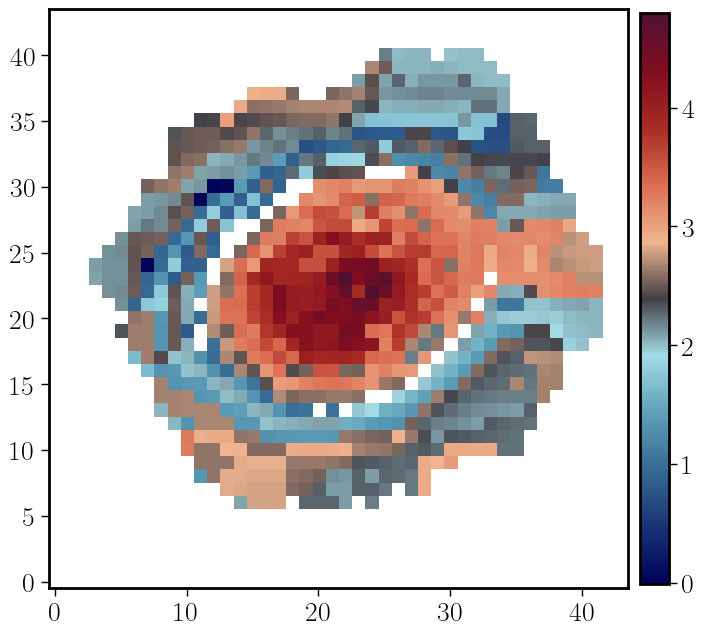

In [28]:
#print(ages)
#print(np.argmin(np.abs(ag10e-3es-32e-3)))
time_to_SFR=32e-3
ind_32=np.argmin(np.abs(ages-time_to_SFR))
#ind_32=11
time_32=ages[ind_32]
print(ind_32,time_32)
Sigma_SFR_32 = (10**(SFH_age_bin[0,:,:])-10**(SFH_age_bin[ind_32,:,:]))/(time_32*1e9)
Sigma_SFR_32 = Sigma_SFR_32*10**(-0.4*SSP_data[11,:,:])
SFR_32Myr=np.nansum(Sigma_SFR_32)
log_SFR_32Myr=np.log10(SFR_32Myr)
#print('SFR_32Myr',log_SFR_32Myr,tab_now['lSFR'],tab_now['log_SFR_ssp'])
log_Sigma_SFR_32= np.log10(Sigma_SFR_32)-np.log10(kpc_to_sp**2)+6
fig, ax = plt.subplots(figsize=(8,8))
norm=colors.PowerNorm(gamma=0.75)
im_now=ax.imshow(log_Sigma_SFR_32, interpolation='none',\
                 cmap=cmap, origin='lower')
fig.colorbar(im_now, ax=ax, orientation='vertical',fraction=0.046, pad=0.02)

  0  ORG_HDR       1 PrimaryHDU      97   ()      
  1  SSP           1 ImageHDU       118   (72, 72, 21)   float64   
  2  SFH           1 ImageHDU      1608   (72, 72, 319)   float64   
  3  INDICES       1 ImageHDU        31   (72, 72, 18)   float64   
  4  ELINES        1 ImageHDU        68   (72, 72, 11)   float64   
  5  FLUX_ELINES    1 ImageHDU      1382   (72, 72, 456)   float64   
  6  FLUX_ELINES_LONG    1 ImageHDU      4622   (72, 72, 1536)   float64   
  7  GAIA_MASK     1 ImageHDU        28   (72, 72)   float64   
  8  SELECT_REG    1 ImageHDU        10   (72, 72)   float64   


44 44 18


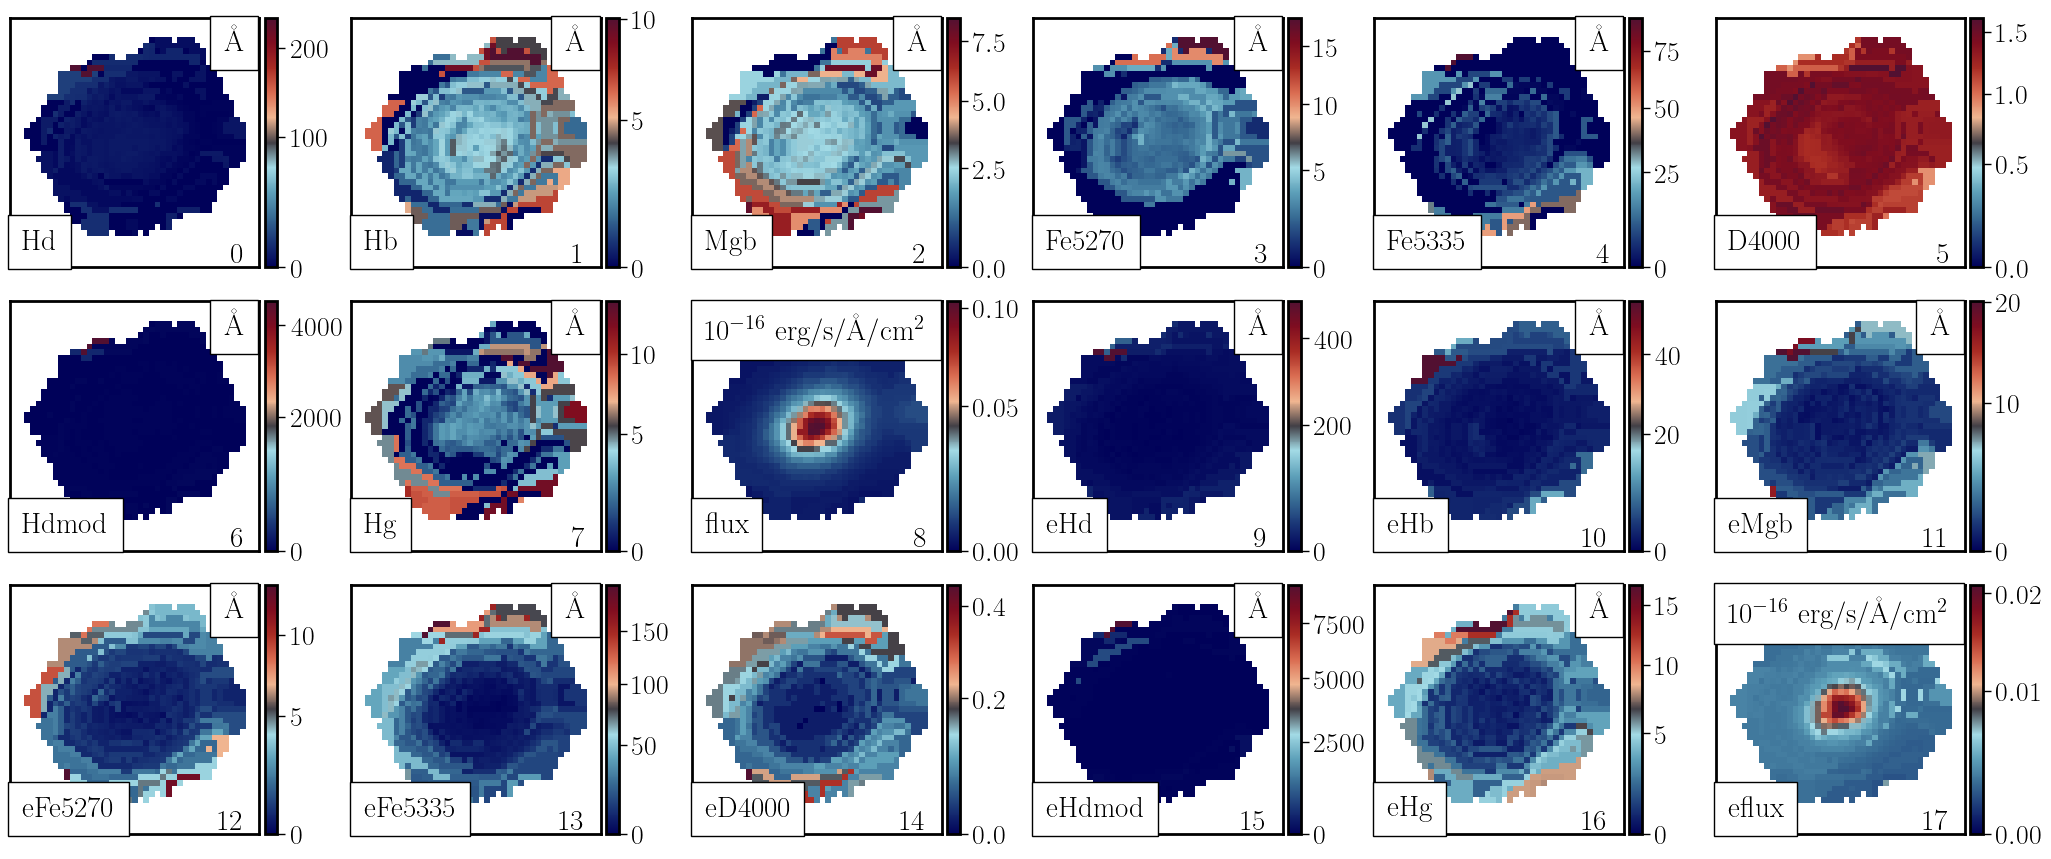

In [29]:
figname=name_now+".IND"
SELECT_REG_data=Pipe3D_hdu[8].data
IND_data=Pipe3D_hdu[3].data
IND_hdr=Pipe3D_hdu[3].header
(nz,ny,nx)=IND_data.shape
IND_maps={}
print(nx,ny,nz)

#print(IND_hdr.keys())
#IND_labels={}#np.zeros(nz)
#IND_ulabels={}#np.zeros(nz)
#for indx,keys in enumerate(list(IND_hdr.keys())):
#    print (keys,IND_hdr[keys])
#    IND_labels[indx]=r'$'+str(IND_hdr[keys])+'$'
#    IND_ulabels[indx]=r'$\AA$'


NY=3
NX=6
fig, axes = plt.subplots(NY,NX, figsize=(int(3.6*NX),int(3*NY)))

color_cm_now = vel_map()
reverse=0
if (reverse==1):
    color_cm_now=color_cm_now.reversed()
cmap=cm.get_cmap(color_cm_now)

for indx,ax in enumerate(axes.flat):
    image=IND_data[indx,:,:]
    image = np.ma.masked_invalid(image)
    image=image*SELECT_REG_data
    image=image*1.0
    mask_img = (image==0)
    image=ma.masked_array(image,mask=mask_img)
    a=image
    x,y=np.mgrid[0:a.shape[0],0:a.shape[1]]
    xygood = np.array((x[~a.mask],y[~a.mask])).T
    xybad = np.array((x[a.mask],y[a.mask])).T
    a[a.mask] = a[~a.mask][KDTree(xygood).query(xybad)[1]]
    image=a
    image=image*SELECT_REG_data
    image=image*1.0
    mask_img = (image==0)
    image=ma.masked_array(image,mask=mask_img)
    keys='INDEX'+str(indx)
    label_now=str(IND_hdr[keys])
    label_now=label_now.replace('_','')
    units_now=r'\AA'
    if (label_now.find('SN')>-1):
            label_now=label_now.replace('SN','flux')
            units_now=r'10$^{-16}$ erg/s/\AA/cm$^2$'
    else:
            image=np.around(image,2)
            

#    print(image)
    vmin=np.nanmin(image)
    vmin=0
    vmax=np.nanmax(image)
    norm=colors.PowerNorm(gamma=0.75,\
                      vmin=vmin,vmax=vmax)
    im_now=ax.imshow(image, interpolation='none',\
                     cmap=cmap, \
                     norm=norm)
    fig.colorbar(im_now, ax=ax, orientation='vertical',fraction=0.046, pad=0.02)
    ax.set_xlim(0,nx)
    ax.set_ylim(0,ny)
    ax.text(0.05*nx, 0.05*ny, label_now, fontsize=21, bbox={'facecolor': 'white', 'pad': 10},\
           va='bottom',ha='left')
    if (label_now.find('D4000')==-1):
        ax.text(0.94*nx, 0.95*ny, units_now, fontsize=21, bbox={'facecolor': 'white', 'pad': 10},\
                va='top',ha='right')
    ax.text(0.94*nx, 0.1*ny, str(indx), fontsize=21,\
            va='top',ha='right')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    #ax.spines['left'].set_visible(False)
#    handles, labels = ax.get_legend_handles_labels()
#    ax.legend(handles, labels,loc=(0.05,0.75),frameon=True,handlelength=1.5)    
#fig.tight_layout()
fig.tight_layout(w_pad=0.35,h_pad=0.35)

fig.savefig(figname+".pdf", transparent=False, facecolor='white', edgecolor='white')#.pdf")

#    SSP_maps[val]=SSP_data[i,:,:]
#print(SSP_maps['pseudo V-band map'])

#print(nx)

44 44 11
11 1.375


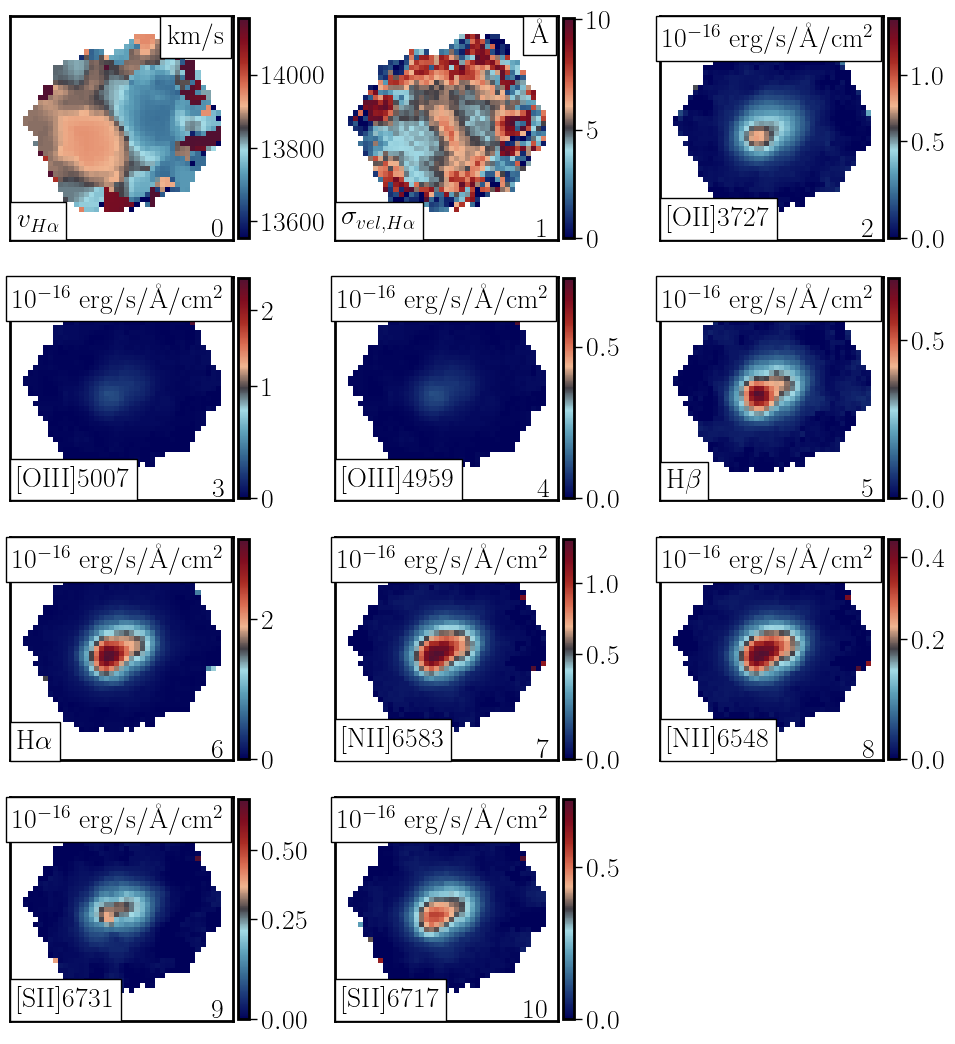

In [30]:
figname=name_now+".ELINES"
SELECT_REG_data=Pipe3D_hdu[8].data
ELINES_data=Pipe3D_hdu[4].data
ELINES_hdr=Pipe3D_hdu[4].header
(nz,ny,nx)=ELINES_data.shape
ELINES_maps={}
print(nx,ny,nz)

nz_bin=nz/8
print(nz,nz_bin)
#print(ELINES_hdr.keys())
#ELINES_labels={}#np.zeros(nz)
#ELINES_ulabels={}#np.zeros(nz)
#for indx,keys in enumerate(list(ELINES_hdr.keys())):
#    print (keys,ELINES_hdr[keys])
#    ELINES_labels[indx]=r'$'+str(ELINES_hdr[keys])+'$'
#    ELINES_ulabels[indx]=r'$\AA$'


NY=4
NX=3
fig, axes = plt.subplots(NY,NX, figsize=(int(3.6*NX),int(2.8*NY)))

color_cm_now = vel_map()
reverse=0
if (reverse==1):
    color_cm_now=color_cm_now.reversed()
cmap=cm.get_cmap(color_cm_now)

for indx,ax in enumerate(axes.flat):
    if (indx<nz):
        image=ELINES_data[indx,:,:]
        image = np.ma.masked_invalid(image)
        image=image*SELECT_REG_data
        image=image*1.0
        mask_img = (image==0)
        image=ma.masked_array(image,mask=mask_img)
        image_Ha=ELINES_data[6,:,:]
        image_Ha = np.ma.masked_invalid(image_Ha)
        image_Ha=image_Ha*SELECT_REG_data
        image_Ha=image_Ha*1.0
        mask_img = (image_Ha==0)
        image_Ha=ma.masked_array(image_Ha,mask=mask_img)
        keys='DESC_'+str(indx)
        keys_u='UNITS_'+str(indx)
        label_now=str(ELINES_hdr[keys])
        label_now=label_now.replace(' emission line','')
        label_now=label_now.replace('Velocity dispersion plus instrumenta one',"$\sigma_{vel,H\\alpha}$")
        label_now=label_now.replace('Halpha velocity',"$v_{H\\alpha}$")
        units_now=str(ELINES_hdr[keys_u])
        vmin=np.nanmin(image)
        if (indx>1):
            vmin=0
            units_now=r'10$^{-16}$ erg/s/\AA/cm$^2$'
        if (indx==1):
            units_now=r'\AA'
        if (label_now.find('Halpha')>-1):
            label_now=r'H$\alpha$'
        if (label_now.find('Hbeta')>-1):
            label_now=r'H$\beta$'
        vmax=np.nanmax(image)
        norm=colors.PowerNorm(gamma=0.75,\
                      vmin=vmin,vmax=vmax)
        if (indx==0):
            vmin=np.ma.median(image)-300
            vmax=np.ma.median(image)+300
            norm=None
        if (indx>1):
            vmin=-0.05
            vmax=np.nanmax(image_Ha)
        if (norm == None):
            im_now=ax.imshow(image, interpolation='none',\
                             cmap=cmap, \
                      vmin=vmin,vmax=vmax)
        else:
            im_now=ax.imshow(image, interpolation='none',\
                             cmap=cmap, \
                     norm=norm)
        fig.colorbar(im_now, ax=ax, orientation='vertical',fraction=0.046, pad=0.02)
        ax.set_xlim(0,nx)
        ax.set_ylim(0,ny)
        ax.text(0.03*nx, 0.03*ny, r''+label_now, fontsize=20, bbox={'facecolor': 'white', 'pad': 5},\
                va='bottom',ha='left')
        ax.text(0.96*nx, 0.97*ny, units_now, fontsize=20, bbox={'facecolor': 'white', 'pad': 5},\
                va='top',ha='right')
        ax.text(0.96*nx, 0.1*ny, str(indx), fontsize=20,\
            va='top',ha='right')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    else:
        ax.set_visible(False)
fig.tight_layout(w_pad=0.8,h_pad=0.35)

fig.savefig(figname+".pdf", transparent=False, facecolor='white', edgecolor='white')#.pdf")

#    SSP_maps[val]=SSP_data[i,:,:]
#print(SSP_maps['pseudo V-band map'])

#print(nx)

44 44 456


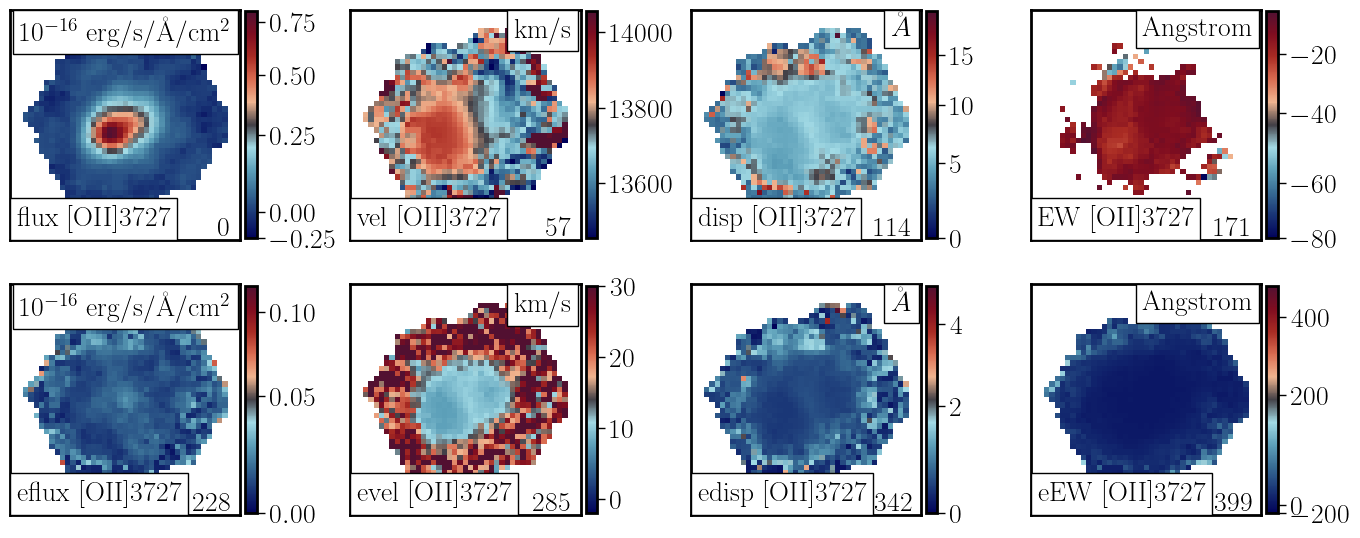

In [31]:
figname=name_now+".FLUX_ELINES"
SELECT_REG_data=Pipe3D_hdu[8].data
ELINES_data=Pipe3D_hdu[5].data
ELINES_hdr=Pipe3D_hdu[5].header
(nz,ny,nx)=ELINES_data.shape
ELINES_maps={}
print(nx,ny,nz)


NY=2
NX=4
fig, axes = plt.subplots(NY,NX, figsize=(int(3.6*NX),int(3*NY)))

color_cm_now = vel_map()
reverse=0
if (reverse==1):
    color_cm_now=color_cm_now.reversed()
cmap=cm.get_cmap(color_cm_now)

start_indx=0
delta_indx=57

for indx,ax in enumerate(axes.flat):
    if (indx<nz):
        indx_now=indx*delta_indx+start_indx
        image=ELINES_data[indx_now,:,:]
        image = np.ma.masked_invalid(image)
        image=image*SELECT_REG_data
        image=image*1.0
        mask_img = (image==0)
        image=ma.masked_array(image,mask=mask_img)
        keys='NAME'+str(indx_now)
        keys_u='UNIT'+str(indx_now)
        label_now=str(ELINES_hdr[keys])
        units_now=str(ELINES_hdr[keys_u])
        vmin=np.nanmin(image)
        vmax=np.nanmax(image)
        norm=colors.PowerNorm(gamma=0.75,vmin=vmin,vmax=vmax)
        label_now=label_now.replace('e_','e')
        if (label_now.find('flux')>-1):            
            units_now=r'10$^{-16}$ erg/s/\AA/cm$^2$'
        if (label_now.find('vel')>-1):
            vmin=np.ma.median(image)-300
            vmax=np.ma.median(image)+300
            norm=None
        if (label_now.find('disp')>-1):
            units_now='$\AA$'
            vmin=-0.1*np.ma.median(image)
            vmax=2*np.ma.median(image)
        if (label_now.find('evel')>-1):
            vmin=-0.1*np.ma.median(image)
            vmax=1.5*np.ma.median(image)
        if (label_now.find('edisp')>-1):
            vmin=-0.1*np.ma.median(image)
            vmax=2*np.ma.median(image)
        if (label_now.find('eflux')>-1):
            vmin=-0.1*np.ma.median(image)
            vmax=2*np.ma.median(image)
        if (label_now.find('eEW')>-1):
            vmin=-0.1*np.ma.median(image)
            vmax=2*np.ma.median(image)

        if (norm == None):
            im_now=ax.imshow(image, interpolation='none',\
                             cmap=cmap, \
                      vmin=vmin,vmax=vmax)
        else:
            im_now=ax.imshow(image, interpolation='none',\
                             cmap=cmap, \
                     norm=norm)           
#        print(indx,vmin,vmax)
#        im_now=ax.imshow(image, interpolation='none',\
#                         cmap=cmap, \
#                     norm=norm,\
#                      vmin=vmin,vmax=vmax)
        fig.colorbar(im_now, ax=ax, orientation='vertical',fraction=0.046, pad=0.02)
        ax.set_xlim(0,nx)
        ax.set_ylim(0,ny)
        ax.text(0.03*nx, 0.03*ny, r''+label_now, fontsize=20, bbox={'facecolor': 'white', 'pad': 5},\
                va='bottom',ha='left')
        ax.text(0.96*nx, 0.97*ny, units_now, fontsize=20, bbox={'facecolor': 'white', 'pad': 5},\
                va='top',ha='right')
        ax.text(0.96*nx, 0.1*ny, str(indx_now), fontsize=20,\
            va='top',ha='right')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    else:
        ax.set_visible(False)
fig.tight_layout(w_pad=1.0,h_pad=0.35)

fig.savefig(figname+".pdf", transparent=False, facecolor='white', edgecolor='white')#.pdf")

#    SSP_maps[val]=SSP_data[i,:,:]
#print(SSP_maps['pseudo V-band map'])

#print(nx)

44 44 1536


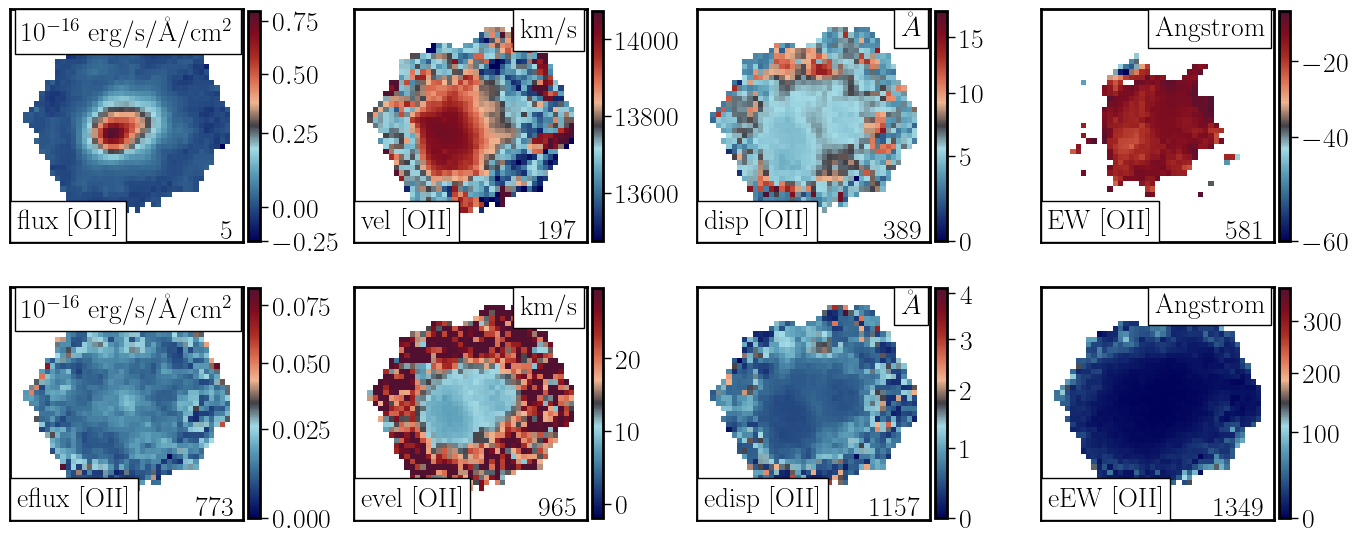

In [32]:
figname=name_now+".FLUX_ELINES_LONG"
SELECT_REG_data=Pipe3D_hdu[8].data
ELINES_data=Pipe3D_hdu[6].data
ELINES_hdr=Pipe3D_hdu[6].header
(nz,ny,nx)=ELINES_data.shape
ELINES_maps={}
print(nx,ny,nz)


NY=2
NX=4
fig, axes = plt.subplots(NY,NX, figsize=(int(3.6*NX),int(3*NY)))

color_cm_now = vel_map()
reverse=0
if (reverse==1):
    color_cm_now=color_cm_now.reversed()
cmap=cm.get_cmap(color_cm_now)

start_indx=5
delta_indx=192

for indx,ax in enumerate(axes.flat):
    if (indx<nz):
        indx_now=indx*delta_indx+start_indx
        image=ELINES_data[indx_now,:,:]
        image = np.ma.masked_invalid(image)
        image=image*SELECT_REG_data
        image=image*1.0
        mask_img = (image==0)
        image=ma.masked_array(image,mask=mask_img)
        keys='NAME'+str(indx_now)
        keys_u='UNIT'+str(indx_now)
        label_now=str(ELINES_hdr[keys])
        units_now=str(ELINES_hdr[keys_u])
        vmin=np.nanmin(image)
        vmax=np.nanmax(image)
        norm=colors.PowerNorm(gamma=0.75,               vmin=vmin,vmax=vmax)
        label_now=label_now.replace('e_','e')
        if (label_now.find('flux')>-1):            
            units_now=r'10$^{-16}$ erg/s/\AA/cm$^2$'
        if (label_now.find('vel')>-1):
            vmin=np.ma.median(image)-300
            vmax=np.ma.median(image)+300
            norm=None
        if (label_now.find('evel')>-1):
            vmin=-0.1*np.ma.median(image)
            vmax=1.5*np.ma.median(image)
        if (label_now.find('disp')>-1):
            units_now='$\AA$'
            vmin=-0.1*np.ma.median(image)
            vmax=2*np.ma.median(image)   
        if (label_now.find('edisp')>-1):
            vmin=-0.1*np.ma.median(image)
            vmax=2*np.ma.median(image)
        if (label_now.find('eflux')>-1):
            vmin=-0.1*np.ma.median(image)
            vmax=2*np.ma.median(image)
        if (label_now.find('eEW')>-1):
            vmin=-0.1*np.ma.median(image)
            vmax=2*np.ma.median(image)

            
#        print(indx,vmin,vmax)

        if (norm == None):
            im_now=ax.imshow(image, interpolation='none',\
                             cmap=cmap, \
                      vmin=vmin,vmax=vmax)
        else:
            im_now=ax.imshow(image, interpolation='none',\
                             cmap=cmap, \
                     norm=norm)           
        #im_now=ax.imshow(image, interpolation='none',\
        #                 cmap=cmap, \
        #             norm=norm,\
        #              vmin=vmin,vmax=vmax)
        fig.colorbar(im_now, ax=ax, orientation='vertical',fraction=0.046, pad=0.02)
        ax.set_xlim(0,nx)
        ax.set_ylim(0,ny)
        ax.text(0.03*nx, 0.03*ny, r''+label_now, fontsize=20, bbox={'facecolor': 'white', 'pad': 5},\
                va='bottom',ha='left')
        ax.text(0.96*nx, 0.97*ny, units_now, fontsize=20, bbox={'facecolor': 'white', 'pad': 5},\
                va='top',ha='right')
        ax.text(0.96*nx, 0.1*ny, str(indx_now), fontsize=20,\
            va='top',ha='right')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    else:
        ax.set_visible(False)
fig.tight_layout(w_pad=1.0,h_pad=0.35)

fig.savefig(figname+".pdf", transparent=False, facecolor='white', edgecolor='white')#.pdf")

#    SSP_maps[val]=SSP_data[i,:,:]
#print(SSP_maps['pseudo V-band map'])

#print(nx)

In [33]:
#
#
#

Text(0, 0.5, 'log($\\Sigma_{SFR}$)')

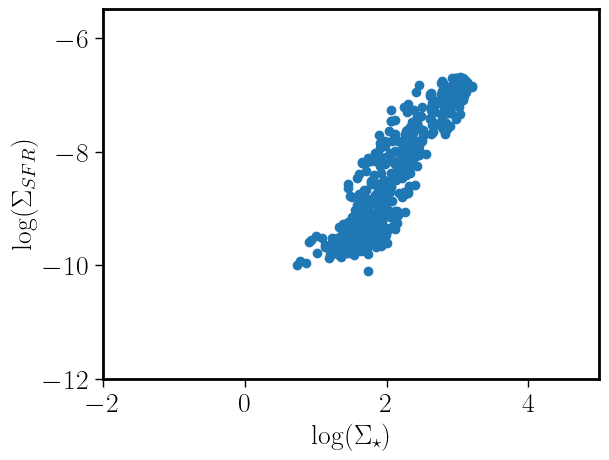

In [34]:
# Need to be masked
plt.scatter(PE_hdu[0].data[9,:,:],PE_hdu[0].data[15,:,:])
plt.xlim(-2,5)
plt.ylim(-12,-5.5)
plt.xlabel(r'log($\Sigma_\star$)')
plt.ylabel(r'log($\Sigma_{SFR}$)')

Text(0, 0.5, 'log($\\Sigma_{mol}$)')

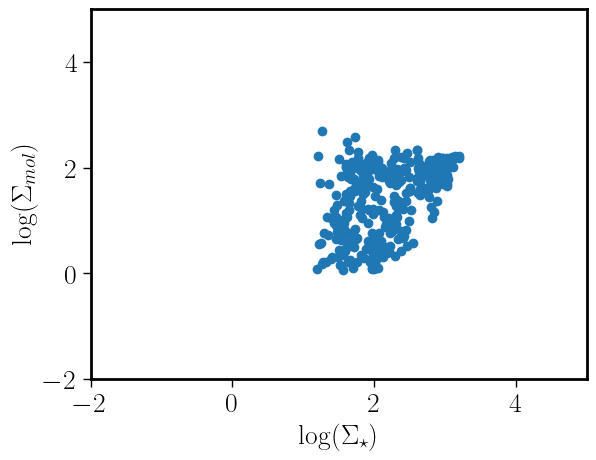

In [35]:
# Need to be masked
plt.scatter(PE_hdu[0].data[9,:,:],PE_hdu[0].data[11,:,:])
plt.xlim(-2,5)
plt.ylim(-2,5)
#plt.ylim(-12,-5.5)
plt.xlabel(r'log($\Sigma_\star$)')
plt.ylabel(r'log($\Sigma_{mol}$)')

Text(0, 0.5, '12+log(O/H) O3N2')

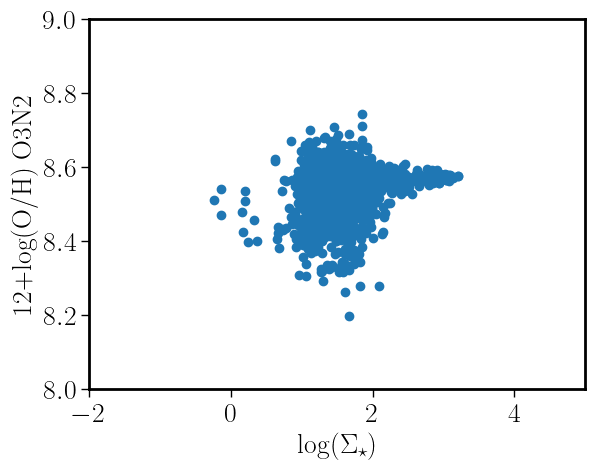

In [36]:
# Need to be masked
plt.scatter(PE_hdu[0].data[9,:,:],OH_hdu[0].data[2,:,:])
plt.xlim(-2,5)
plt.ylim(8,9)
plt.xlabel(r'log($\Sigma_\star$)')
plt.ylabel(r'12+log(O/H) O3N2')

Text(0, 0.5, '12+log(O/H) O3N2')

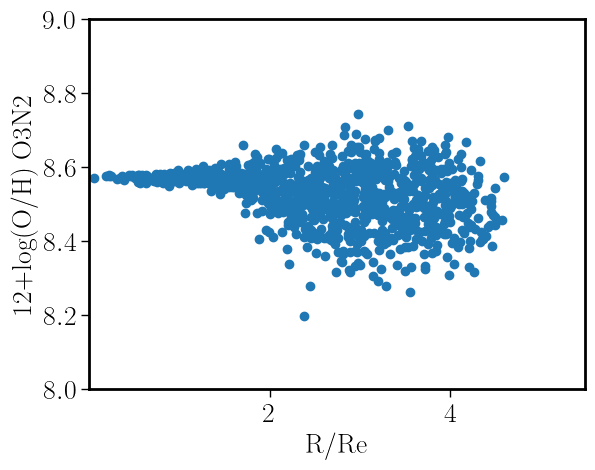

In [37]:
# Need to be masked
plt.scatter(PE_hdu[0].data[1,:,:],OH_hdu[0].data[2,:,:])
plt.xlim(0.001,5.5)
plt.ylim(8,9)
plt.xlabel(r'R/Re')
plt.ylabel(r'12+log(O/H) O3N2')

Text(0, 0.5, 'log($\\Sigma_{SFR}$)')

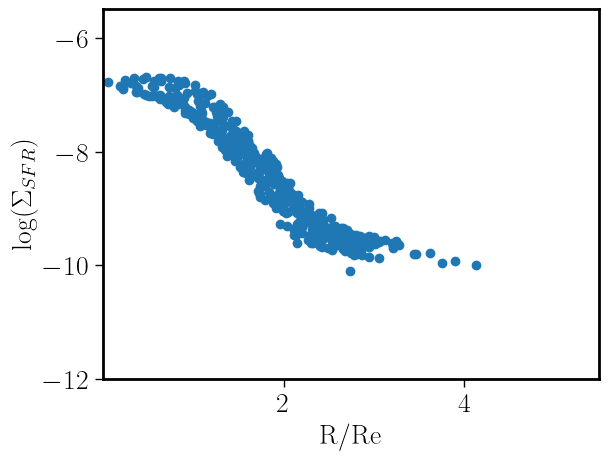

In [38]:
# Need to be masked
plt.scatter(PE_hdu[0].data[1,:,:],PE_hdu[0].data[15,:,:])
plt.xlim(0.001,5.5)
plt.ylim(-12,-5.5)
plt.xlabel(r'R/Re')
plt.ylabel(r'log($\Sigma_{SFR}$)')
#plt.ylabel(r'12+log(O/H) O3N2')